# Client Churn Prediction
---

The Top Bank company operates in Europe with a bank account as the main product, this product can keep client's salary and make payments. This account doesn't have any cost in the first 12 months, however, after that time trial, the client needs to rehire the bank for upcoming 12 months and redo this process every year. Recently the Analytics Team noticed that the churn rate is increasing.

As a Data Science Consultant, you need to create an action plan to decrease the number of churn customers and show the financial return on your solution.
At the end of your consultancy, you need to deliver to the TopBottom CEO a model in production, which will receive a customer base via API and return that same base with an extra column with the probability of each customer going into churn.
In addition, you will need to provide a report reporting your model's performance and the financial impact of your solution. Questions that the CEO and the Analytics team would like to see in their report:

1.  What is Top Bank's current Churn rate?
2.  How does the churn rate vary monthly?
3.  What is the performance of the model in classifying customers as churns
4.  What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

> Disclaimer: This is a fictional bussiness case

## 0. PREPARATION

### 0.1 Planning

### Input

- Predict wheter customer will be in churn;
- Dataset with sales records and customers info.

### Output

- Which customer will be in churn;
- Churn rate of the company;
- Performance of the model;
- Action plan


### Tasks

1. Which customer will be in churn:
    - What is the criterion?
        - Downtime
        - Time remaining until the contract ends


2. Current churn rate of the company:
    - Calculate churn rate
    - Calculate monthly churn rate and variation

3. Performance of the model:
    - Precision at K score
    - Recall at K score

4. Action plan:
    - Discount?
    - Voucher?
    - Deposit bonus?



### 0.2 Imports

In [1]:
import warnings
import inflection

import pandas               as pd
import numpy                as np
import seaborn              as sns
import sweetviz             as sv
import yellowbrick          as yb
import fastparquet          as fp
import matplotlib.pyplot    as plt

from tqdm.notebook          import tqdm
from scipy                  import stats
from typing                 import Union
from IPython.core.display   import Image, HTML

from sklearn.model_selection import train_test_split


/home/gutto/repos/github/client_churn_prediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def jupyter_settings():
    
    """
    Plots pre settings.
    """


    %matplotlib inline
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

sns.set_style('white')

# ignoring errors
warnings.filterwarnings('ignore')

# round
pd.options.display.float_format = '{:.3f}'.format

# random state seed
seed = 42


### 0.3 Helper Functions

In [3]:
def life_stage(data: Union[int, float, str], age: int):

    """
    Shows the life stage of the given age.

    Args:
        data ([dataframe]): [Select the dataframe to create the life_stage column]
        age ([object]): [The column where the ages are]
    """

    
    data['life_stage'] = data[age].apply(lambda x: 'adolescence' if x <= 20 else 'adulthood' if (
    x > 20) & (x <= 35) else 'middle_age' if (x > 35) & (x <= 50) else 'senior')


def verify_nan(dataframe: Union[int, str]):

    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    sum_na = dataframe.isna().sum()
    
    return pd.DataFrame({'Sum of NA': sum_na, '%NA': sum_na/dataframe.shape[0]})


def numerical_metrics(data: Union[int, str]):

    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    
    data_mean = pd.DataFrame(data.apply(np.mean)).T
    data_median = pd.DataFrame(data.apply(np.median)).T
    data_std = pd.DataFrame(data.apply(np.std)).T
    data_min = pd.DataFrame(data.apply(min)).T
    data_max = pd.DataFrame(data.apply(max)).T
    data_range = pd.DataFrame(data.apply(lambda x: x.max() - x.min())).T
    data_q1 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .25) )).T
    data_q3 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .75) )).T
    data_skew = pd.DataFrame(data.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(data.apply(lambda x: x.kurtosis())).T
    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median, data_q1, data_q3,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns = ['attributes','min','max','range','mean','median','q1','q3', 'st deviation','skewness','kurtosis']

    return num_attributes


def categorical_metrics(data: Union[int, str], col: str):

    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with absolute and percent values]
    """
    

    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })

In [4]:
def plot_with_target(target_x: Union[int, float, str], target_y: Union[int, float, str], col: str, position_x: int, position_y: int, label_x: str, label_y: str):
    """
    Create some histplots with target feature.

    Returns:
        [Image]: [Histplots of all features with target]
    """
    
    ax[position_x, position_y].hist(target_x[col], bins = 50, alpha = 0.5, label= label_x) 
    ax[position_x, position_y].hist(target_y[col], bins = 50, alpha = 0.7, label= label_y) 
    ax[position_x, position_y].legend()
    ax[position_x, position_y].set_title(col)

    return ax


def multiple_histplots(data: Union[int, float, str], rows: int, cols: int):
    """
    Shows a matrix with hisplots of selected features.

    Args:
        data ([dataframe]): [Insert all categorical attributes in the dataset]
        rows ([int]): [Insert the number of rows of the subplot]
        cols ([int]): [Insert the number of columns of the subplot]

    Returns:
        [Image]: [A matrix plot with histplots]
    """

    for i, col in enumerate(data.columns, 1):
        plt.subplot(rows, cols, i)
        ax = sns.histplot(data[col], kde = True)
        plt.ylabel('')

    return ax


def bivariate_bins_churn(first: int, last: int, step: int, data: Union[int, float, str], feature: str):

    """
    Create a binned countplot.

    Returns:
        [Image]: [countplots]
    """

    
    # creating bins
    bins = np.arange(first, last, step)

    # creating an aux dataframe
    aux1 = data[[feature, 'exited']]
    aux1['feature_binned'] = pd.cut(aux1[feature], bins = bins)

    # separating in churn and not churn
    aux2 = aux1.loc[aux1['exited'] == 1, :]
    aux3 = aux1.loc[aux1['exited'] != 1, :]

    # creating subplots
    plt.subplot(1,2,1)
    ax = sns.countplot(x = 'feature_binned', data = aux2).set_title('Churn')
    plt.xticks(rotation = 90);

    plt.subplot(1,2,2)
    ax = sns.countplot(x = 'feature_binned', data = aux3).set_title('Not in churn')
    plt.xticks(rotation = 90);

    return ax


def bivariate_churn_plots(data: Union[int, float, str], feature: str):

    """
    Create some plots for the EDA step. Including displots and boxplots.

    Args:
        data ([dataframe]): [Insert the dataset]
        feature ([object]): [The feature for the validation]

    Returns:
        [Image]: [Some plots of the feature analysis]
    """


    # creating subplots
    fig, ax = plt.subplots()

    plt.subplot(1, 2, 1)
    ax1 = sns.distplot(data[data['exited'] == 1][feature], label = 'churn', color = '#1F77B4')
    ax1 = sns.distplot(data[data['exited'] == 0][feature], label = 'not in churn', color = '#FF7F0E')
    plt.legend(['churn', 'not in churn']);

    plt.subplot(1, 2, 2)
    ax2 = sns.boxplot(data = data, y = 'exited', x = feature)
    plt.legend(['churn', 'not in churn']);

    return ax 


def correlation_ascending(data: Union[int, float, str], col: str, method: str):
    """Generates a correlation matrix of each numerical variables in ascending order.

    Args:
        data ([dataFrame]): [The dataframe of the EDA]
        col ([object]): [The column selected]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """

    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    correlation = num_attributes.corr(method = method)

    correlation_asc = correlation[col].sort_values(ascending=False).to_frame()
    correlation_asc.columns = ['']
    correlation_asc.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( correlation_asc, annot=True, cmap='rocket').set_title(col);
    
    return plot


def correlation_matrix(data: Union[int, float], method: str):
    """Generates a correlation matrix of numerical variables

    Args:
        data ([DataFrame]): [The dataframe of the EDA]
        cols_drop ([list]): [Cols to drop]
        method ([string]): [The method used, it can be ‘pearson’, ‘kendall’ or ‘spearman’]

    Returns:
        [Image]: [The correlation matrix plot made with seaborn]
    """
    
    # correlation
    num_attributes = data.select_dtypes(include = ['int64', 'float64'])
    correlation = num_attributes.corr(method = method)

    # plot
    ax = sns.heatmap(correlation, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True)

    return ax


def cramers_v(categorical_attributes: Union[str, int]):
    """Calculates Cramer's V

    Args:
        categorical_attributes ([DataFrame]): [The dataframe with all categorical features]


    Returns:
        [Dict]: [Dictionary with cramer's V]
    """

    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            cm = pd.crosstab(categorical_attributes[ref], categorical_attributes[feat]).to_numpy()
            n = cm.sum()
            r, k = cm.shape
            chi2 = stats.chi2_contingency(cm)[0]
            chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
            kcorr = k - (k-1)**2/(n-1)
            rcorr = r - (r-1)**2/(n-1)
            corr = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
            corr_list.append(corr)
        
        corr_dict[ref]= corr_list
    
    return corr_dict



def highlight_max(s):
    # Only apply highlight in int and float
    if s.dtype == np.object:
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: #F15854' if cell else '' for cell in is_max]

### 0.4 Data

This dataset is avaliable [here](https://www.kaggle.com/mervetorkan/churndataset).


**Data fields**

- **RowNumber**: the number of the columns
- **CustomerID**: unique identifier of clients
- **Surname**: client's last name
- **CreditScore**: clien'ts credit score for the financial market
- **Geography**: the country of the client
- **Gender**: the gender of the client
- **Age**: the client's age
- **Tenure**: number of years the client is in the bank 
- **Balance**: the amount that the client has in their account 
- **NumOfProducts**: the number of products that the client bought 
- **HasCrCard**: if the client has a credit card 
- **IsActiveMember**: if the client is active (within the last 12 months) 
- **EstimateSalary**: estimative of anual salary of clients 
- **Exited**: if the client is a churn (*target variable*)

In [5]:
homepath = '/home/gutto/repos/github/client_churn_prediction/'

# Loading data and Saving as parquet
df_raw = pd.read_csv(homepath + 'data/raw/churn.csv')
fp.write(homepath + 'data/processed/churn.parquet', df_raw)


## 1. DATA DESCRIPTION

### 1.1 Dataset First Look

In [6]:
df1 = pd.read_parquet(homepath + 'data/processed/churn.parquet', engine='fastparquet')
df1.head().T

,0,1,2,3,4
RowNumber,1,2,3,4,5
CustomerId,15634602,15647311,15619304,15701354,15737888
Surname,Hargrave,Hill,Onio,Boni,Mitchell
CreditScore,619,608,502,699,850
Geography,France,Spain,France,France,Spain
Gender,Female,Female,Female,Female,Female
Age,42,41,42,39,43
Tenure,2,1,8,1,2
Balance,0.000,83807.860,159660.800,0.000,125510.820
NumOfProducts,1,1,3,2,1


### 1.2 Organizing

In [7]:
# change to snake_case tyle
cols_old = df1.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))
df1.columns = cols_new

# reordering columns
df1 = df1.reindex(columns=['customer_id', 'row_number', 'surname', 'is_active_member', 'exited', 'has_cr_card', 'credit_score', 'num_of_products', 'estimated_salary', 'balance', 'tenure', 'age', 'gender', 'geography'])
df1.head()

,customer_id,row_number,surname,is_active_member,exited,has_cr_card,credit_score,num_of_products,estimated_salary,balance,tenure,age,gender,geography
0,15634602,1,Hargrave,1,1,1,619,1,101348.880,0.000,2,42,Female,France
1,15647311,2,Hill,1,0,0,608,1,112542.580,83807.860,1,41,Female,Spain
2,15619304,3,Onio,0,1,1,502,3,113931.570,159660.800,8,42,Female,France
3,15701354,4,Boni,0,0,0,699,2,93826.630,0.000,1,39,Female,France
4,15737888,5,Mitchell,1,0,1,850,1,79084.100,125510.820,2,43,Female,Spain


### 1.3 Data Dimensions

In [8]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 10000 
Number of columns: 14


### 1.4 Check Data

In [9]:
df1.isna().sum()

customer_id         0
row_number          0
surname             0
is_active_member    0
exited              0
has_cr_card         0
credit_score        0
num_of_products     0
estimated_salary    0
balance             0
tenure              0
age                 0
gender              0
geography           0
dtype: int64

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   row_number        10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   is_active_member  10000 non-null  int64  
 4   exited            10000 non-null  int64  
 5   has_cr_card       10000 non-null  int64  
 6   credit_score      10000 non-null  int64  
 7   num_of_products   10000 non-null  int64  
 8   estimated_salary  10000 non-null  float64
 9   balance           10000 non-null  float64
 10  tenure            10000 non-null  int64  
 11  age               10000 non-null  int64  
 12  gender            10000 non-null  object 
 13  geography         10000 non-null  object 
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Some features are categorial but has some encoding technique.

`is_active_member`, `exited` and `has_cr_card` should be strings

There's no NA in this dataset, however, there's a possibility that there are zeros in place of NAs

In [11]:
df1_verify = df1[['credit_score', 'num_of_products', 'estimated_salary', 'balance', 'age']]

for col in df1_verify.columns:
    df1_verify[col] = df1_verify[col].apply(lambda x: 'another_value' if x != 0 else 'zero')

In [12]:
df1_verify.apply(lambda x: x.unique())


credit_score              [another_value]
num_of_products           [another_value]
estimated_salary          [another_value]
balance             [zero, another_value]
age                       [another_value]
dtype: object

In [13]:
df1_verify['balance'].value_counts()

balance
another_value    6383
zero             3617
Name: count, dtype: int64

The balance columns has more than 1/3 of zero values, it doesn't mean that they're missing values but the DS team should get more information about this.

### 1.5 Change d-types

In [14]:
df1_cat = df1.copy()
col_cat = ['has_cr_card', 'is_active_member', 'exited']


for col in col_cat:
    df1_cat[col] = df1_cat[col].apply(lambda x: 'yes' if x == 1 else 'no')

### 1.6 Descriptive Statistics

#### 1.6.1 Numerical Attributes

In [15]:
num_attributes = df1_cat.select_dtypes(include = ['int64', 'float64'])
num_attributes.drop(columns = ['row_number', 'customer_id'], inplace = True)

In [16]:
numerical_metrics(num_attributes)

,attributes,min,max,range,mean,median,q1,q3,st deviation,skewness,kurtosis
0,credit_score,350.000,850.000,500.000,650.529,652.000,584.000,718.000,96.648,-0.072,-0.426
1,num_of_products,1.000,4.000,3.000,1.530,1.000,1.000,2.000,0.582,0.746,0.583
2,estimated_salary,11.580,199992.480,199980.900,100090.240,100193.915,51002.110,149388.247,57507.617,0.002,-1.182
3,balance,0.000,250898.090,250898.090,76485.889,97198.540,0.000,127644.240,62394.285,-0.141,-1.489
4,tenure,0.000,10.000,10.000,5.013,5.000,3.000,7.000,2.892,0.011,-1.165
5,age,18.000,92.000,74.000,38.922,37.000,32.000,44.000,10.487,1.011,1.395


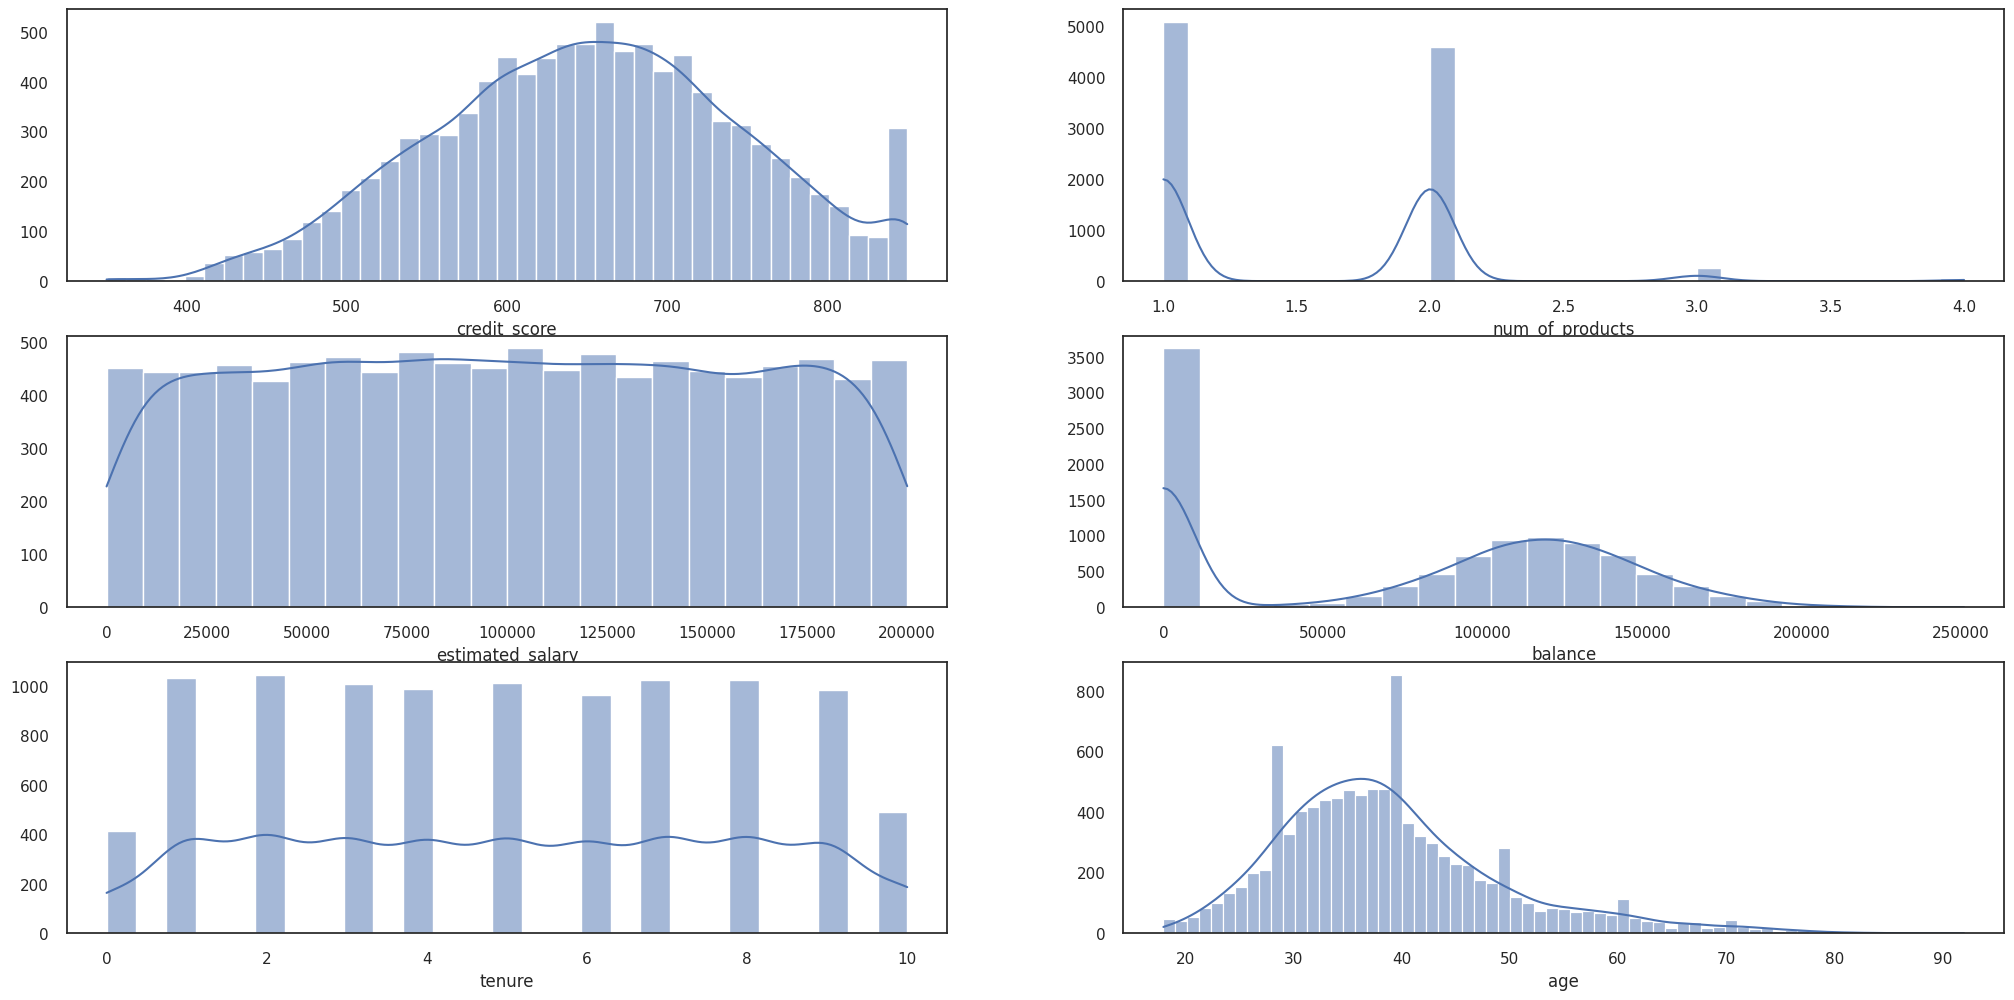

In [17]:
multiple_histplots(num_attributes, 3, 2);

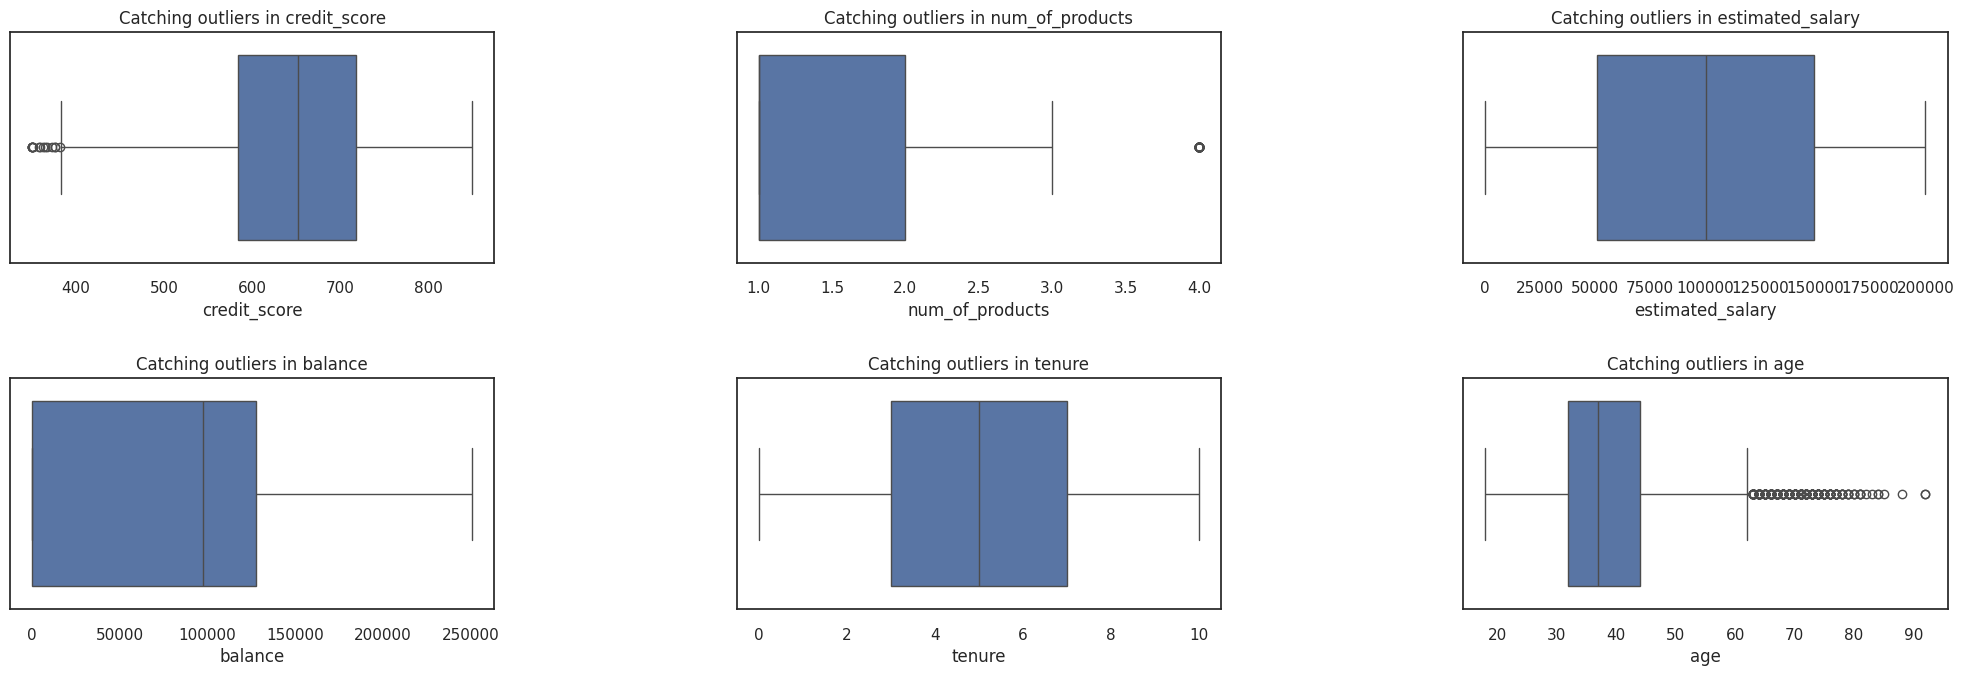

In [18]:
num_cols = num_attributes.columns.tolist()

i = 1
for col in df1[num_cols]:
    plt.subplot(3, 3, i)
    ax = sns.boxplot(data = df1, x = col, orient = 'h')
    ax.title.set_text(f'Catching outliers in {col}')
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    i += 1
    
# saving figure 
plt.savefig(homepath + 'reports/figures/numerical_attributes.png')


Negative outliers in `credit_score` and positive outliers in `num_of_products` and `age`

#### 1.6.2 Categorical Attributes

In [19]:

cat_attributes = df1_cat.select_dtypes(exclude = ['int64', 'float64'])
cat_attributes.drop(columns = 'surname', inplace = True)

In [20]:
categorical_metrics(cat_attributes, 'is_active_member')

,absolute,percent %
is_active_member,,
yes,5151,51.510
no,4849,48.490


In [21]:

categorical_metrics(cat_attributes, 'has_cr_card')

,absolute,percent %
has_cr_card,,
yes,7055,70.550
no,2945,29.450


In [22]:

categorical_metrics(cat_attributes, 'exited')

,absolute,percent %
exited,,
no,7963,79.630
yes,2037,20.370


In [23]:

categorical_metrics(cat_attributes, 'gender')

,absolute,percent %
gender,,
Male,5457,54.570
Female,4543,45.430


In [24]:

categorical_metrics(cat_attributes, 'geography')

,absolute,percent %
geography,,
France,5014,50.140
Germany,2509,25.090
Spain,2477,24.770


Important informations:
- There are outliers in **credit_score, num_of_products and age**
- The **churn ratio is 20.37%**;
- **70.6%** of the members **has credit card**;
- More than **50% of the clients** are **from France**

### 1.7 Data Filtering

In [25]:
# Removing unwanted columns
df1.drop(columns = ['row_number', 'surname'], inplace = True)

### 1.8 Save State

In [26]:
fp.write(homepath + 'data/processed/df1.parquet', df1)

## 2. FEATURE ENGINEERING

### 2.1 Split Data

In [27]:
df2 = pd.read_parquet(homepath + 'data/processed/df1.parquet', engine='fastparquet')

# Train -> 70%
# Test -> 20%
# Validation -> 10%
x_train, x_test = train_test_split(df2 , test_size = 0.2, random_state = seed)

# if train = 80% x dataset, then val = 0.1/0.8 = 0.125
# 0.125 x 0.8 = 0.1
x_train, x_val = train_test_split(x_train, test_size = 0.125, random_state = seed)

### 2.2 Feature Creation

In [28]:
# credit_score_per_gender
credit_per_gender_train, credit_per_gender_test, credit_per_gender_val = [dataframe.loc[:, ['gender', 'credit_score']].groupby('gender').mean().reset_index() for dataframe in [x_train, x_test, x_val]]

credit_per_gender_train.columns = ['gender', 'credit_score_per_gender']
credit_per_gender_test.columns = ['gender', 'credit_score_per_gender']
credit_per_gender_val.columns = ['gender', 'credit_score_per_gender']

x_train = pd.merge(x_train, credit_per_gender_train, on = 'gender', how = 'left')
x_test = pd.merge(x_test, credit_per_gender_test, on = 'gender', how = 'left')
x_val = pd.merge(x_val, credit_per_gender_val, on = 'gender', how = 'left')


# balance_age
balance_age_train, balance_age_test, balance_age_val = [dataframe.loc[:, ['age', 'balance']].groupby('age').mean().reset_index() for dataframe in [x_train, x_test, x_val]]

balance_age_train.columns = ['age', 'balance_per_age']
balance_age_test.columns = ['age', 'balance_per_age']
balance_age_val.columns = ['age', 'balance_per_age']

x_train = pd.merge(x_train, balance_age_train, on = 'age', how = 'left')
x_test = pd.merge(x_test, balance_age_test, on = 'age', how = 'left')
x_val = pd.merge(x_val, balance_age_val, on = 'age', how = 'left')


# estimated_salary_per_country
estimated_salary_country_train, estimated_salary_country_test, estimated_salary_country_val = [dataframe.loc[:, ['geography', 'estimated_salary']].groupby('geography').mean().reset_index() for dataframe in [x_train, x_test, x_val]]

estimated_salary_country_train.columns = ['geography', 'estimated_salary_per_country']
estimated_salary_country_test.columns = ['geography', 'estimated_salary_per_country']
estimated_salary_country_val.columns = ['geography', 'estimated_salary_per_country']

x_train = pd.merge(x_train, estimated_salary_country_train, on = 'geography', how = 'left')
x_test = pd.merge(x_test, estimated_salary_country_test, on = 'geography', how = 'left')
x_val = pd.merge(x_val, estimated_salary_country_val, on = 'geography', how = 'left')

# LTV
balance_tenure_train, balance_tenure_test, balance_tenure_val = [dataframe.loc[:, ['tenure', 'balance']].groupby('tenure').mean().reset_index() for dataframe in [x_train, x_test, x_val]]

balance_tenure_train.columns = ['tenure', 'ltv']
balance_tenure_test.columns = ['tenure', 'ltv']
balance_tenure_val.columns = ['tenure', 'ltv']

x_train = pd.merge(x_train, balance_tenure_train, on = 'tenure', how = 'left')
x_test = pd.merge(x_test, balance_tenure_test, on = 'tenure', how = 'left')
x_val = pd.merge(x_val, balance_tenure_val, on = 'tenure', how = 'left')

# tenure_per_country
tenure_country_train, tenure_country_test, tenure_country_val = [dataframe.loc[:, ['geography', 'tenure']].groupby('geography').mean().reset_index() for dataframe in [x_train, x_test, x_val]]

tenure_country_train.columns = ['geography', 'tenure_per_country']
tenure_country_test.columns = ['geography', 'tenure_per_country']
tenure_country_val.columns = ['geography', 'tenure_per_country']

x_train = pd.merge(x_train, tenure_country_train, on = 'geography', how = 'left')
x_test = pd.merge(x_test, tenure_country_test, on = 'geography', how = 'left')
x_val = pd.merge(x_val, tenure_country_val, on = 'geography', how = 'left')

### 2.3 Verify NA

In [29]:
verify_nan(x_train)

,Sum of NA,%NA
customer_id,0,0.000
is_active_member,0,0.000
exited,0,0.000
has_cr_card,0,0.000
credit_score,0,0.000
num_of_products,0,0.000
estimated_salary,0,0.000
balance,0,0.000
tenure,0,0.000
age,0,0.000


In [30]:
verify_nan(x_test)

,Sum of NA,%NA
customer_id,0,0.000
is_active_member,0,0.000
exited,0,0.000
has_cr_card,0,0.000
credit_score,0,0.000
num_of_products,0,0.000
estimated_salary,0,0.000
balance,0,0.000
tenure,0,0.000
age,0,0.000


In [31]:
verify_nan(x_val)

,Sum of NA,%NA
customer_id,0,0.000
is_active_member,0,0.000
exited,0,0.000
has_cr_card,0,0.000
credit_score,0,0.000
num_of_products,0,0.000
estimated_salary,0,0.000
balance,0,0.000
tenure,0,0.000
age,0,0.000


### 2.4 Final Cut

In [32]:
y_train, y_test, y_val = [dataframe['exited'] for dataframe in [x_train, x_test, x_val]]
ids_train, ids_test, ids_val = [dataframe['customer_id'] for dataframe in [x_train, x_test, x_val]]
X_train, X_test, X_val = [dataframe.drop(columns = ['exited', 'customer_id']) for dataframe in [x_train, x_test, x_val]]

### 2.5 Save State

In [33]:
fp.write(homepath + 'data/processed/x_train.parquet', x_train)
fp.write(homepath + 'data/processed/x_test.parquet', x_test)
fp.write(homepath + 'data/processed/x_val.parquet', x_val)

fp.write(homepath + 'data/processed/X_train.parquet', X_train)
fp.write(homepath + 'data/processed/X_test.parquet', X_test)
fp.write(homepath + 'data/processed/X_val.parquet', X_val)

#fp.write(homepath + 'data/processed/y_train.parquet', y_train)
#fp.write(homepath + 'data/processed/y_test.parquet', y_test)
#fp.write(homepath + 'data/processed/y_val.parquet', y_val)

#fp.write(homepath + 'data/processed/ids_train.parquet', ids_train)
#fp.write(homepath + 'data/processed/ids_test.parquet', ids_test)
#fp.write(homepath + 'data/processed/ids_val.parquet', ids_val)

## 3. EXPLORATORY DATA ANALYSIS

### 3.1 Dataset Checkpoint

In [34]:
df3 = pd.read_parquet(homepath + 'data/processed/x_train.parquet', engine='fastparquet')


### 3.2 Mind Map

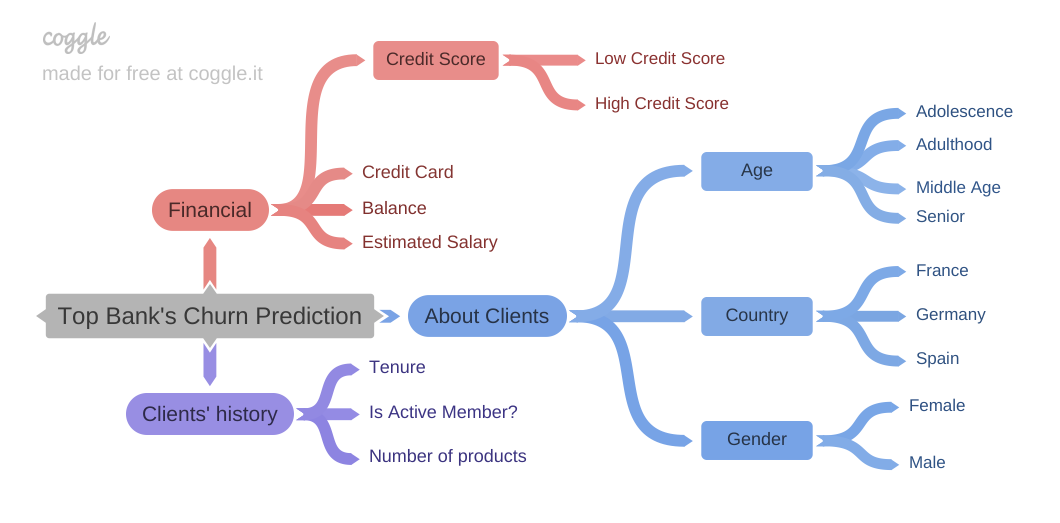

In [35]:
Image(homepath + 'reports/figures/mind_map.png')

### 3.3 Reports

#### 3.3.1 Overview

In [36]:
report_overview = sv.analyze(df3, target_feat ='exited')
report_overview.show_html(filepath = homepath + 'reports/report_overview.html', open_browser = False, layout = 'vertical', scale = None)


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)

Report /home/gutto/repos/github/client_churn_prediction/reports/report_overview.html was generated.


#### 3.3.2 Gender Comparation

In [37]:
gender_comparation = sv.compare_intra(df3, df3['gender'] == 'Male', ['Male', 'Female'], target_feat = 'exited')
gender_comparation.show_html(filepath = homepath + 'reports/gender_comparation.html', open_browser = False, layout = 'vertical', scale = None)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)

Report /home/gutto/repos/github/client_churn_prediction/reports/gender_comparation.html was generated.


#### 3.3.3 Warnings

- balance has 36% zeros.
- tenure has 4% zeros.
- there are more women in churn (24%) than men (16%).
- not active members has more chance to be in churn (24%) than active members (16%).
- has_cr_card seems to have no relevance to the phenomenon.
- France has 50% of the clients of the bank but Germany has the highest churn ratio.

### 3.4 Univariate Analysis

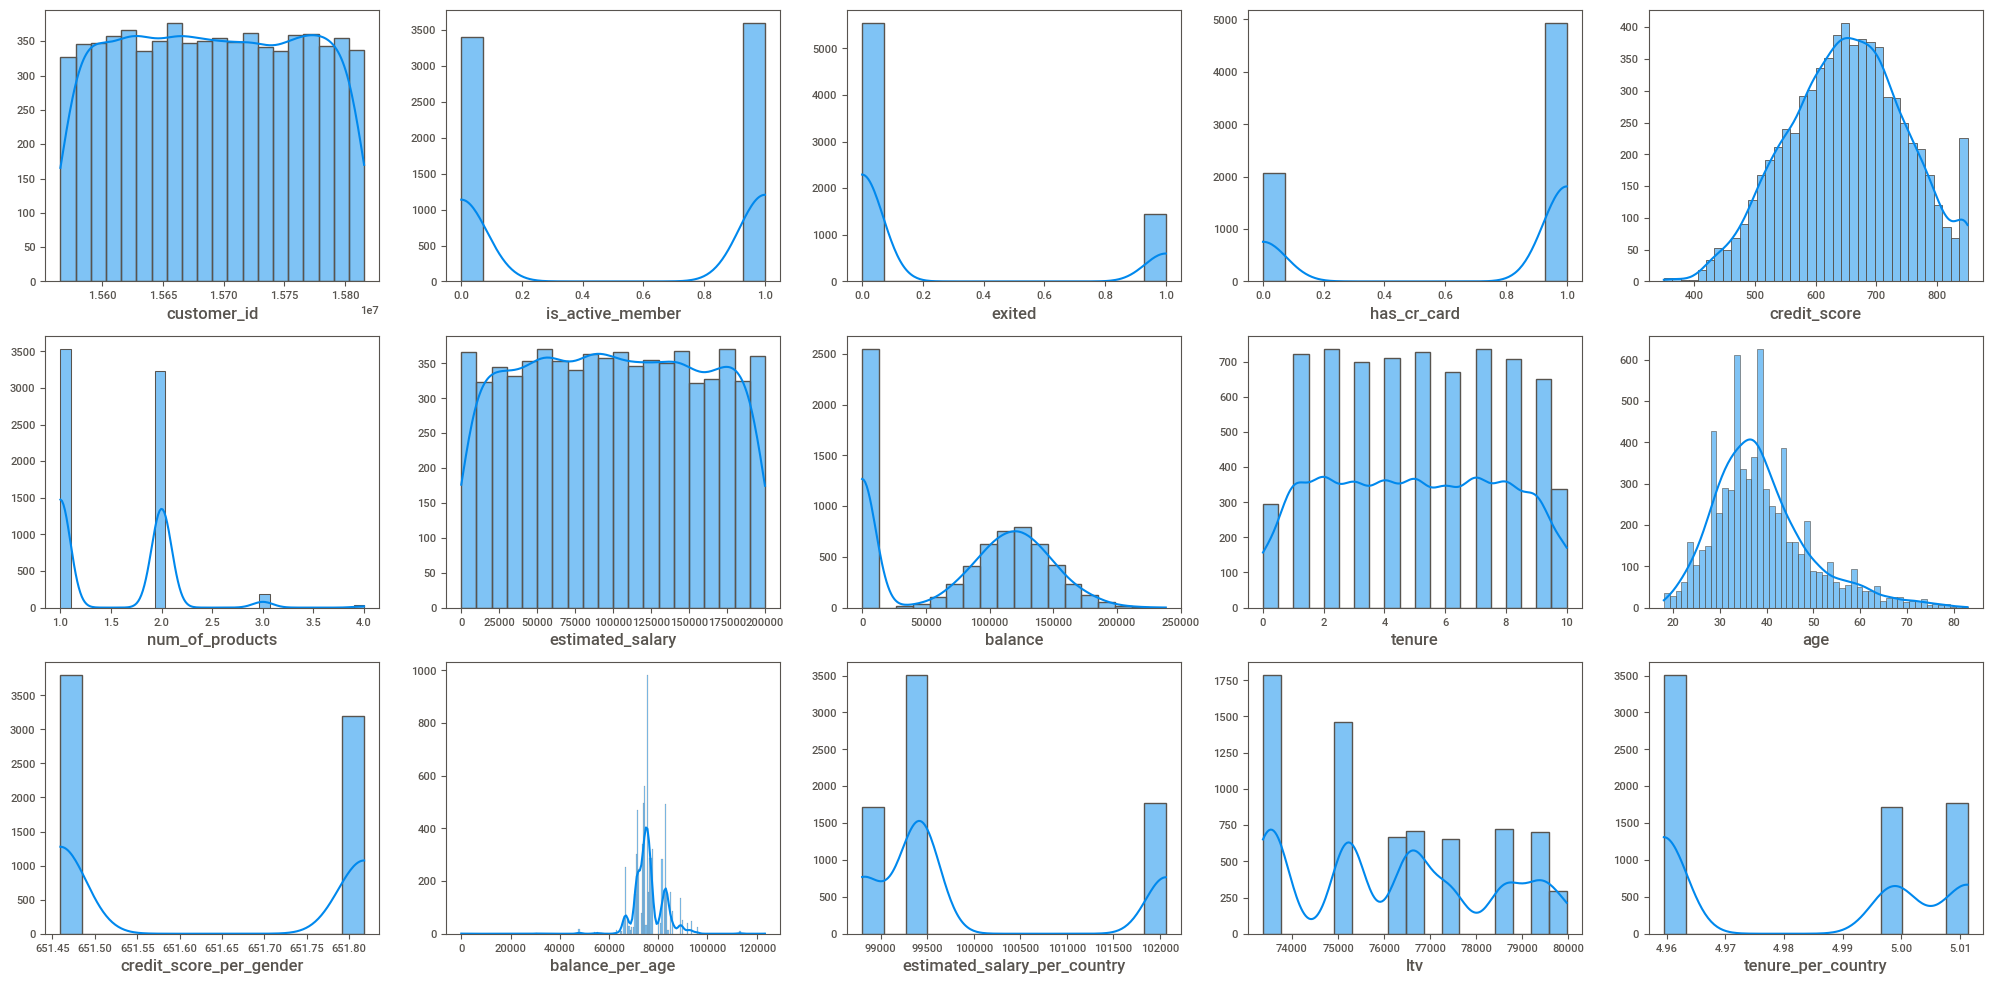

In [38]:
univariate_numerical = df3.select_dtypes(include=['int64', 'float64'])
multiple_histplots(univariate_numerical, 3, 5)

#saving figure
plt.savefig(homepath + 'reports/figures/univariate_analysis.png')


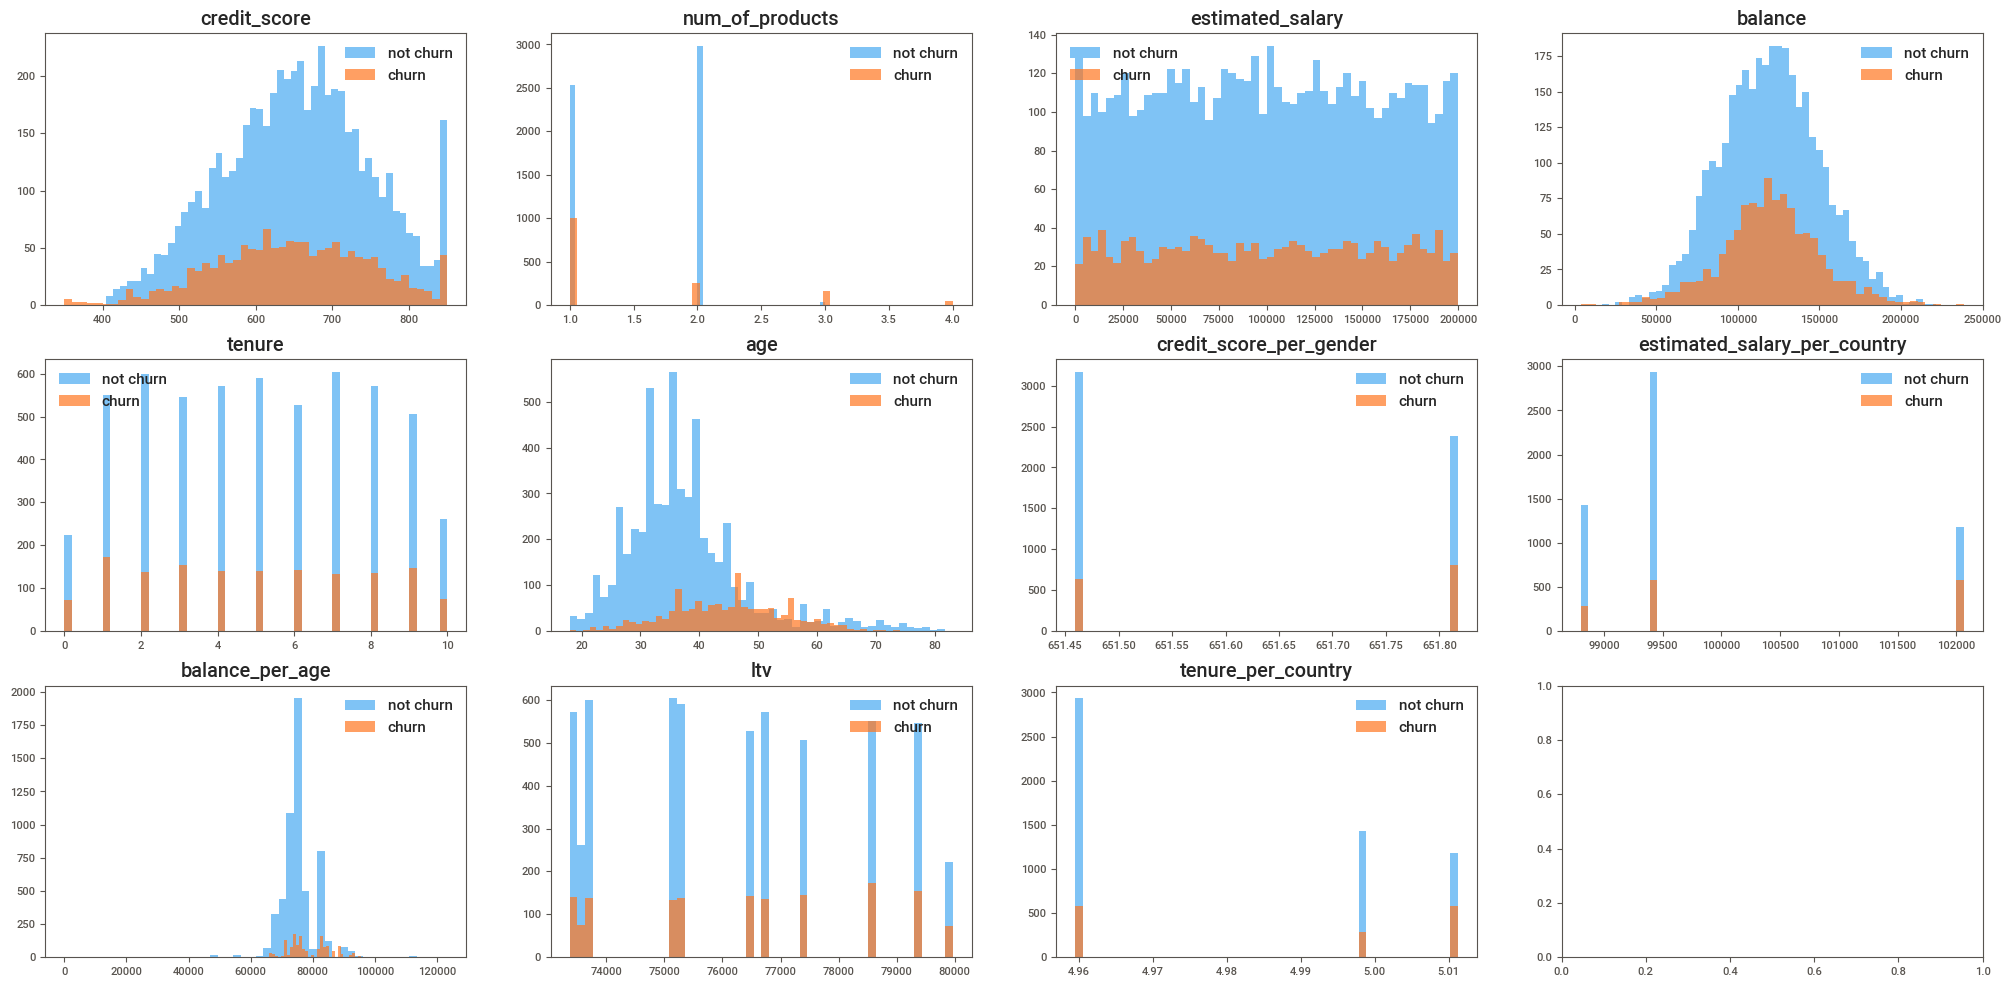

In [39]:
# Plot with target
univariate_numerical['exited'] = df3['exited']

# creating two datasets, one with churn and other with not churn hue
numerical_churn = univariate_numerical[univariate_numerical['exited'] == 1]
numerical_not_churn = univariate_numerical[univariate_numerical['exited'] == 0]

# creating aux datasets
aux_churn = numerical_churn[numerical_churn['balance'] != 0]
aux_not_churn = numerical_not_churn[numerical_not_churn['balance'] != 0]

# creating subplots
fig, ax = plt.subplots(3, 4)

# plot
plot_with_target(numerical_not_churn, numerical_churn,
                 'credit_score', 0, 0, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'num_of_products', 0, 1, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'estimated_salary', 0, 2, 'not churn', 'churn')
plot_with_target(aux_not_churn, aux_churn, 'balance',
                 0, 3, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'tenure', 1, 0, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'age', 1, 1, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'credit_score_per_gender', 1, 2, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'estimated_salary_per_country', 1, 3, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'balance_per_age', 2, 0, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'ltv', 2, 1, 'not churn', 'churn')
plot_with_target(numerical_not_churn, numerical_churn,
                 'tenure_per_country', 2, 2, 'not churn', 'churn')

#saving figure
plt.savefig(homepath + 'reports/figures/univariate_analysis_target.png')


### 4.5 Bivariate Analysis

#### 4.5.1 List of hypotheses

Number | Hypotheses
---    | ---
1      | Elderly clients has more tendency to be churn.
2      | Elderly people tend to not be in churn.
3      | Clients with more products has less tendency to be churn.
4      | Clients with a bad credit score tend to be in churn.
5      | Clients with higher estimated salaries tend to be in churn.

#### 4.5.2 Validation

#### **H1** Elderly clients has more tendency to be churn.
**True** Seniors has a higher churn tendency than others.

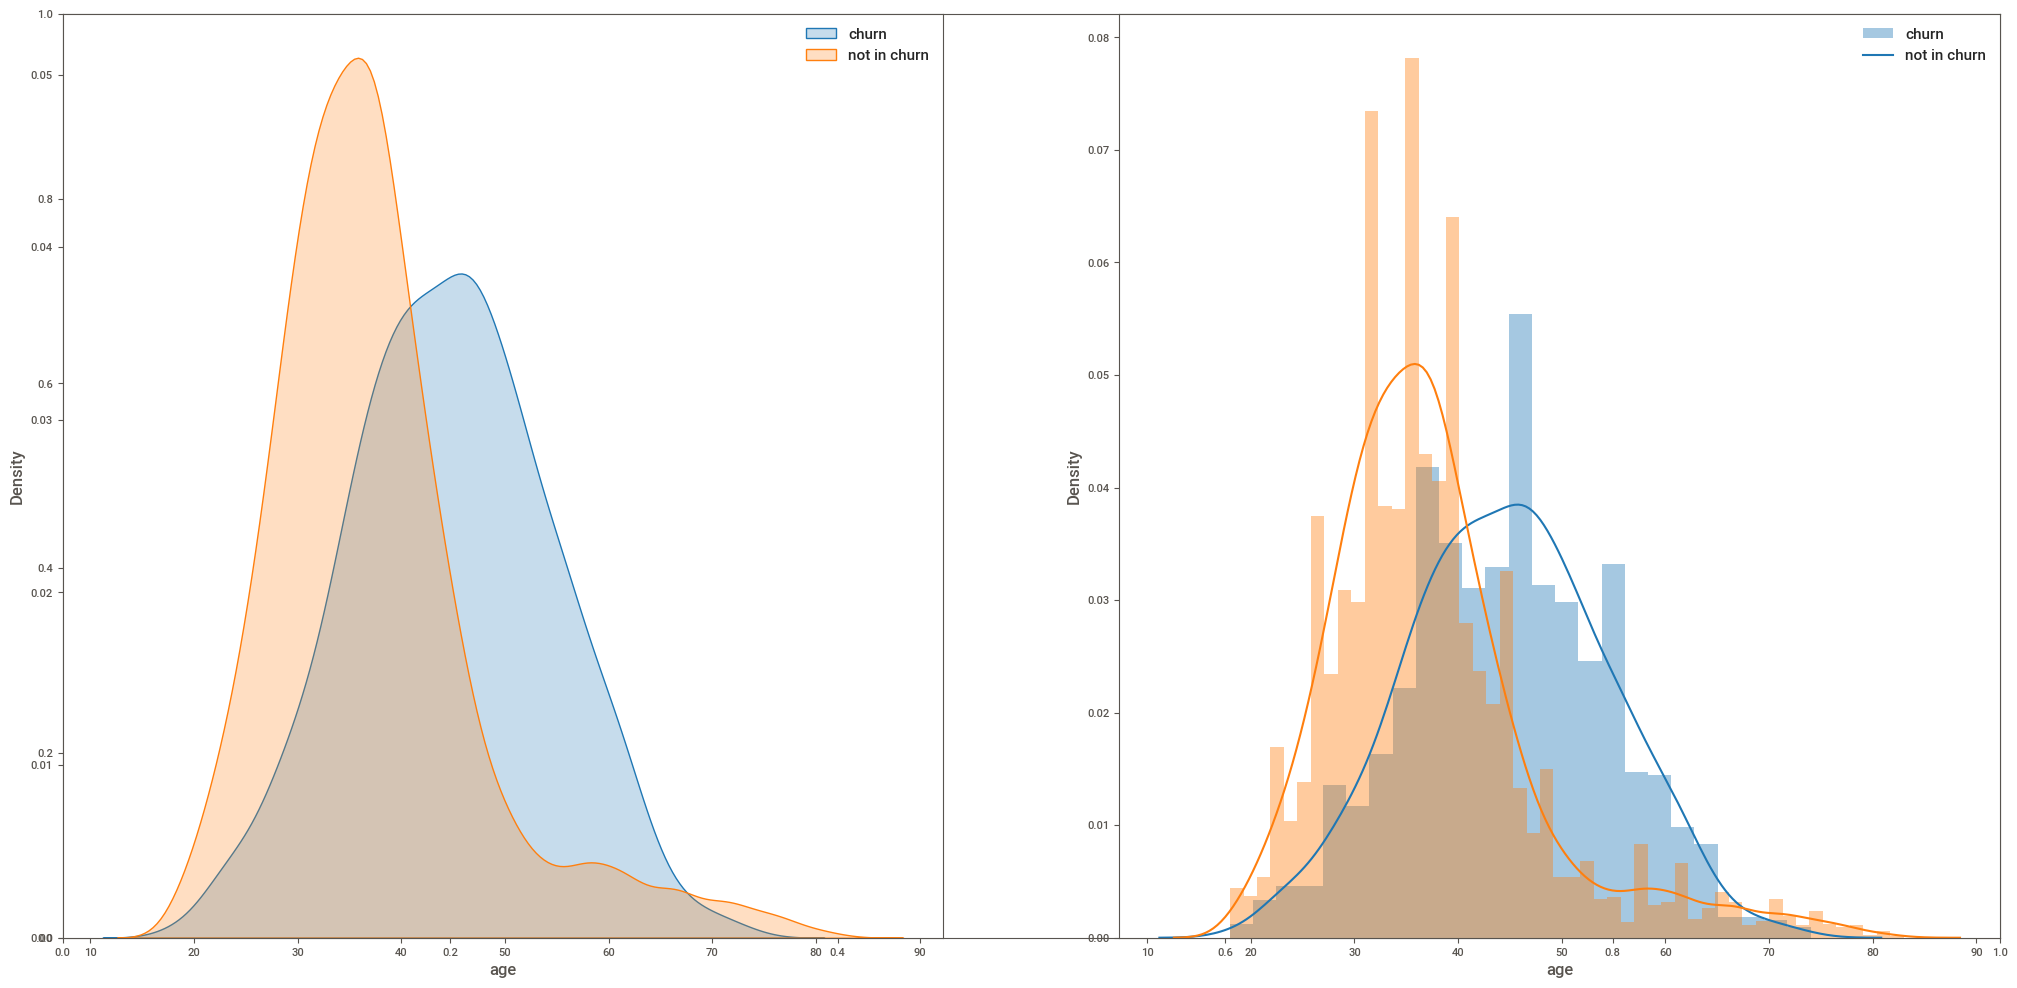

In [40]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(1, 2, 1)
ax = sns.kdeplot(df3[df3['exited'] == 1]['age'], label = 'churn', shade = True, color = '#1F77B4')
ax = sns.kdeplot(df3[df3['exited'] == 0]['age'], label = 'not in churn', shade = True, color = '#FF7F0E')
plt.legend(['churn', 'not in churn']) ;

plt.subplot(1, 2, 2)
ax2 = sns.distplot(df3[df3['exited'] == 1]['age'], label = 'churn', color = '#1F77B4')
ax2 = sns.distplot(df3[df3['exited'] == 0]['age'], label = 'not in churn', color = '#FF7F0E')
plt.legend(['churn', 'not in churn']);

#saving figure
plt.savefig(homepath + 'reports/figures/h1a.png')

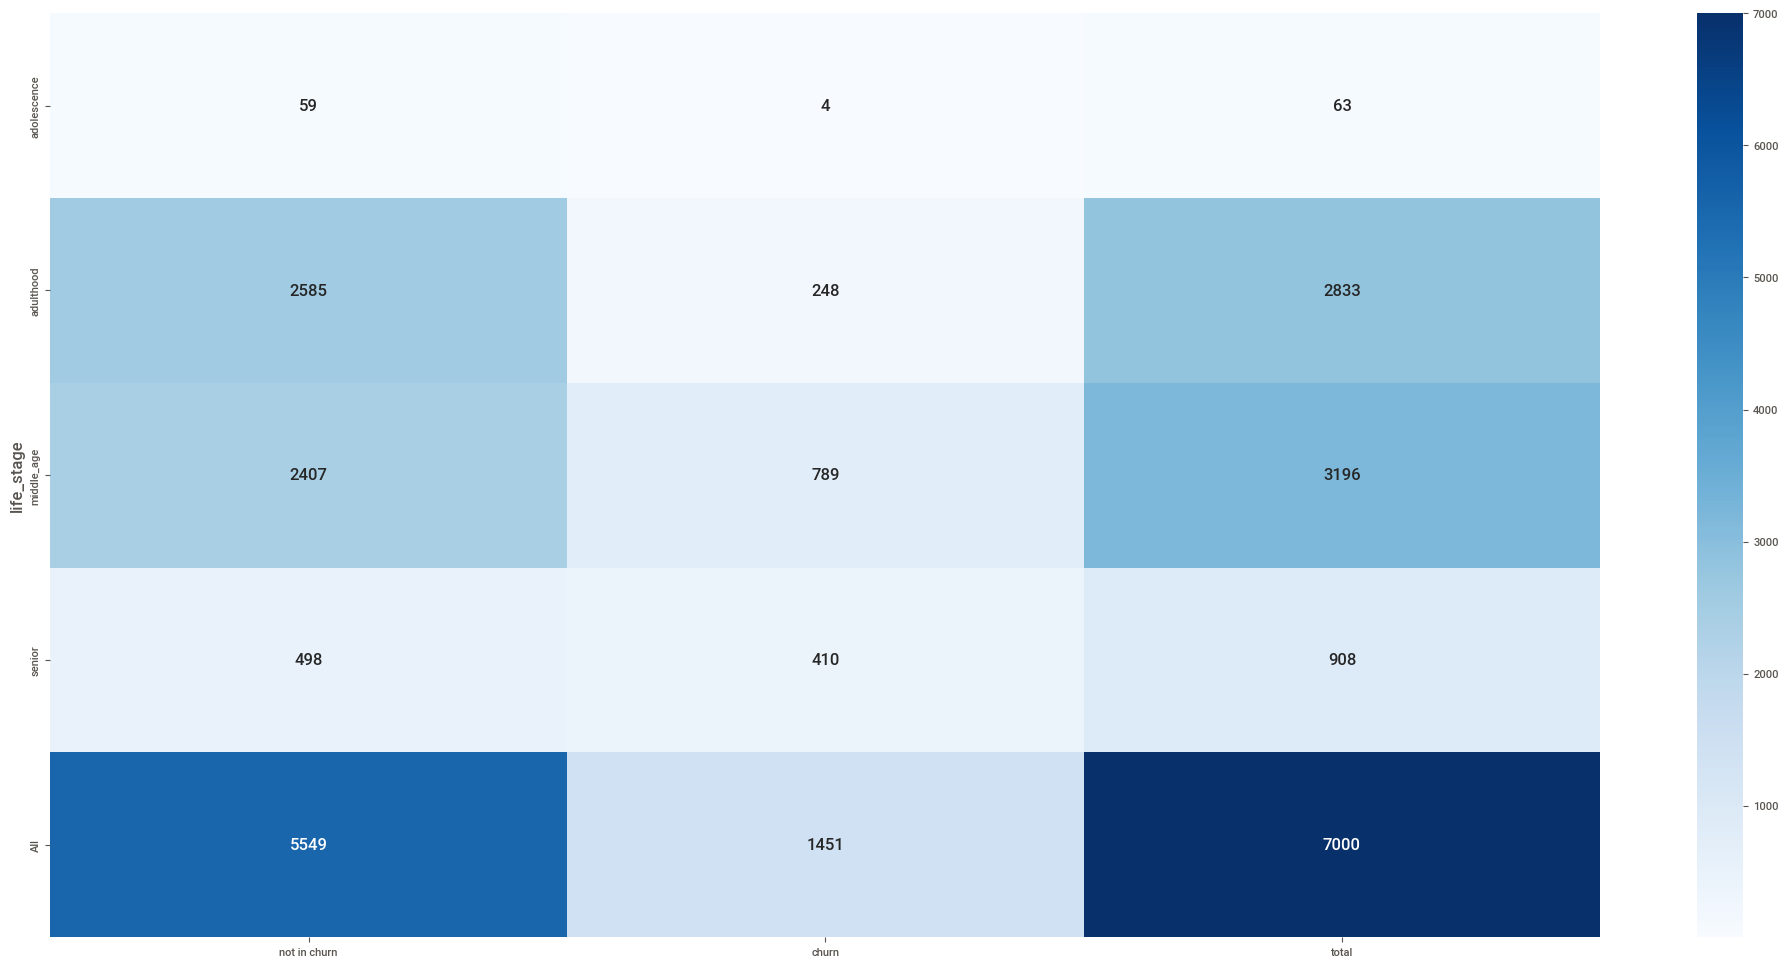

In [41]:
aux1 = df3[['has_cr_card', 'age', 'exited']]
life_stage(aux1, 'age')

aux2 = aux1.pivot_table(values='has_cr_card',index='life_stage',columns='exited',aggfunc=['count'], margins = True)
aux2.columns = ['not in churn', 'churn', 'total']

ax = sns.heatmap(aux2, fmt = 'g', annot = True, cmap = 'Blues')

#saving figure
plt.savefig(homepath + 'reports/figures/h1b.png')

In [42]:
life_stage = ['adolescence' ,'adulthood' ,'middle_age', 'senior']
churn_percentage = [5/89*100, 332/4054*100, 1082/4541*100, (542/1240)*100]
h1 = pd.DataFrame({'life stage': life_stage, 'churn %': churn_percentage})
h1

,life stage,churn %
0,adolescence,5.618
1,adulthood,8.189
2,middle_age,23.827
3,senior,43.710


#### **H2** Elderly people tend to not be in churn.
**False** In proportion, clients with 60 years and above has more tendency to be in churn than adolescents and adults.

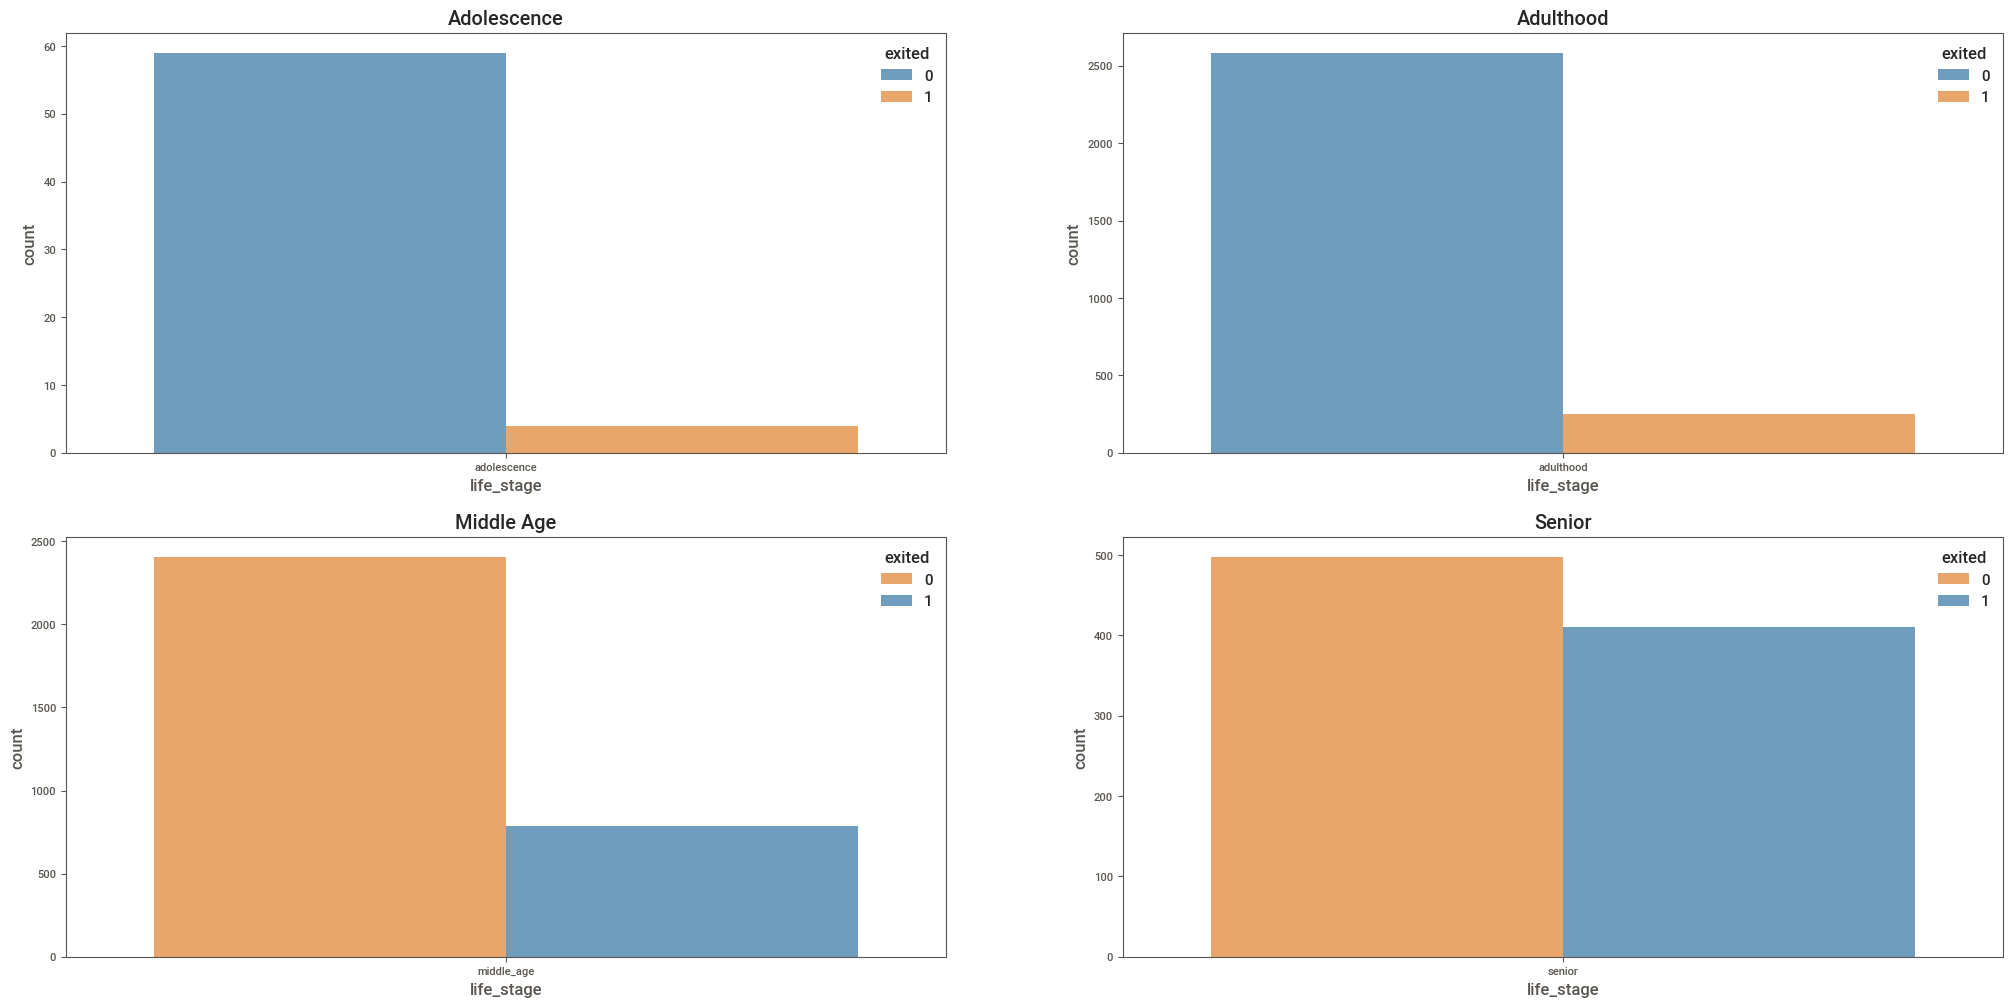

In [43]:
# creating aux dataframes
aux = df3[['age', 'balance', 'exited']].copy()
aux['life_stage'] = aux['age'].apply(lambda x: 'adolescence' if x <= 20 else 'adulthood' if (
    x > 20) & (x <= 35) else 'middle_age' if (x > 35) & (x <= 50) else 'senior')


# creating subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# plot
aux1 = aux.loc[(aux['life_stage'] == 'adolescence'), :] 
ax1 = sns.countplot(data = aux1, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#1F77B4', '#FF7F0E'], ax = ax1).set_title('Adolescence')

aux2 = aux.loc[(aux['life_stage'] == 'adulthood'), :] 
ax2 = sns.countplot(data = aux2, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#1F77B4', '#FF7F0E'], ax = ax2).set_title('Adulthood')

aux3 = aux.loc[(aux['life_stage'] == 'middle_age'), :] 
ax3 = sns.countplot(data = aux3, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#FF7F0E', '#1F77B4'], ax = ax3).set_title('Middle Age')

aux4 = aux.loc[(aux['life_stage'] == 'senior'), :] 
ax4 = sns.countplot(data = aux4, x = 'life_stage', hue = 'exited', alpha = 0.7, palette = ['#FF7F0E', '#1F77B4'], ax = ax4).set_title('Senior')

#saving figure
plt.savefig(homepath + 'reports/figures/h2.png')

In [44]:
categorical_metrics(aux, 'life_stage')

,absolute,percent %
life_stage,,
middle_age,3196,45.657
adulthood,2833,40.471
senior,908,12.971
adolescence,63,0.900


#### **H3** Clients with more products has less tendency to be churn.
**False** Clients with more products has more tendency to be churn.

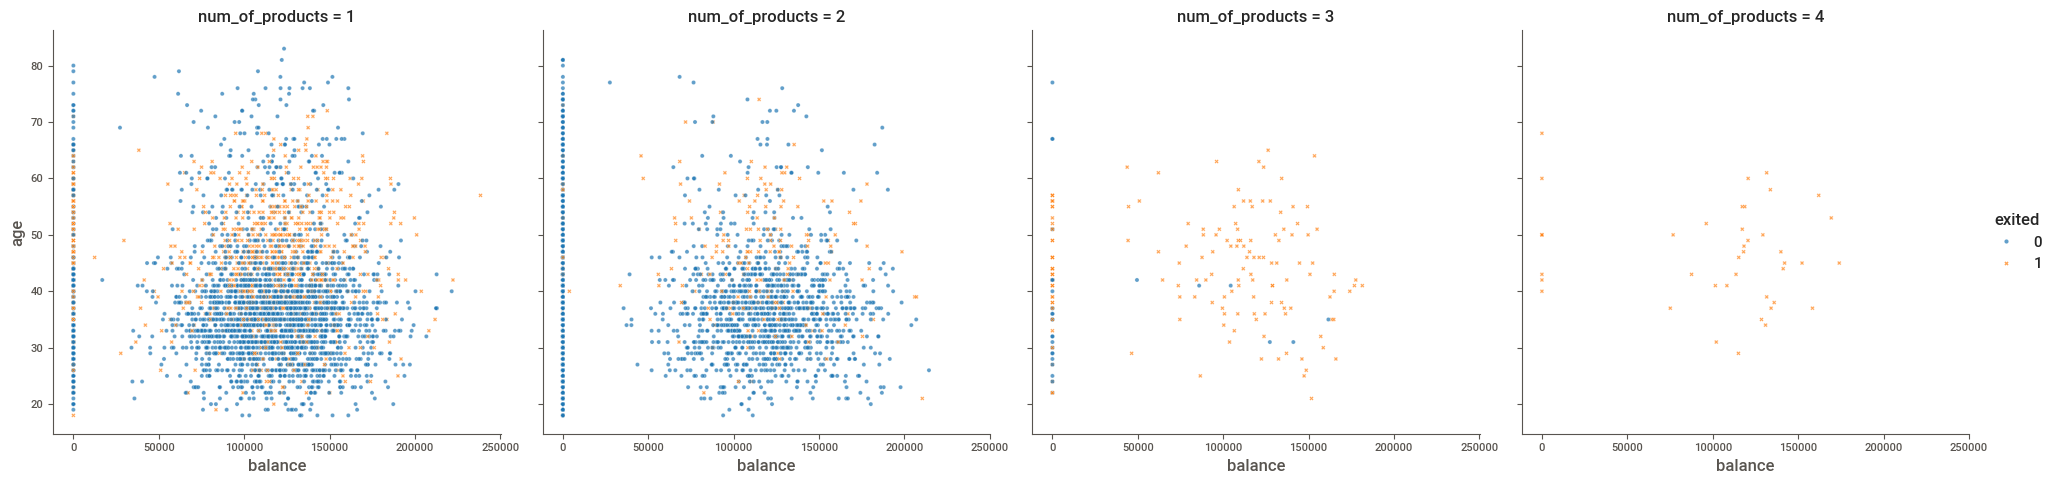

In [45]:
ax = sns.relplot(data = df3, x = 'balance', y = 'age', col = 'num_of_products', hue = 'exited', style = 'exited', alpha = 0.7, palette = 'tab10')

#saving figure
plt.savefig(homepath + 'reports/figures/h3.png')

#### **H4** Clients with a bad credit score tend to be in churn.
**False** Low and high credit score has a low relevance in churn.

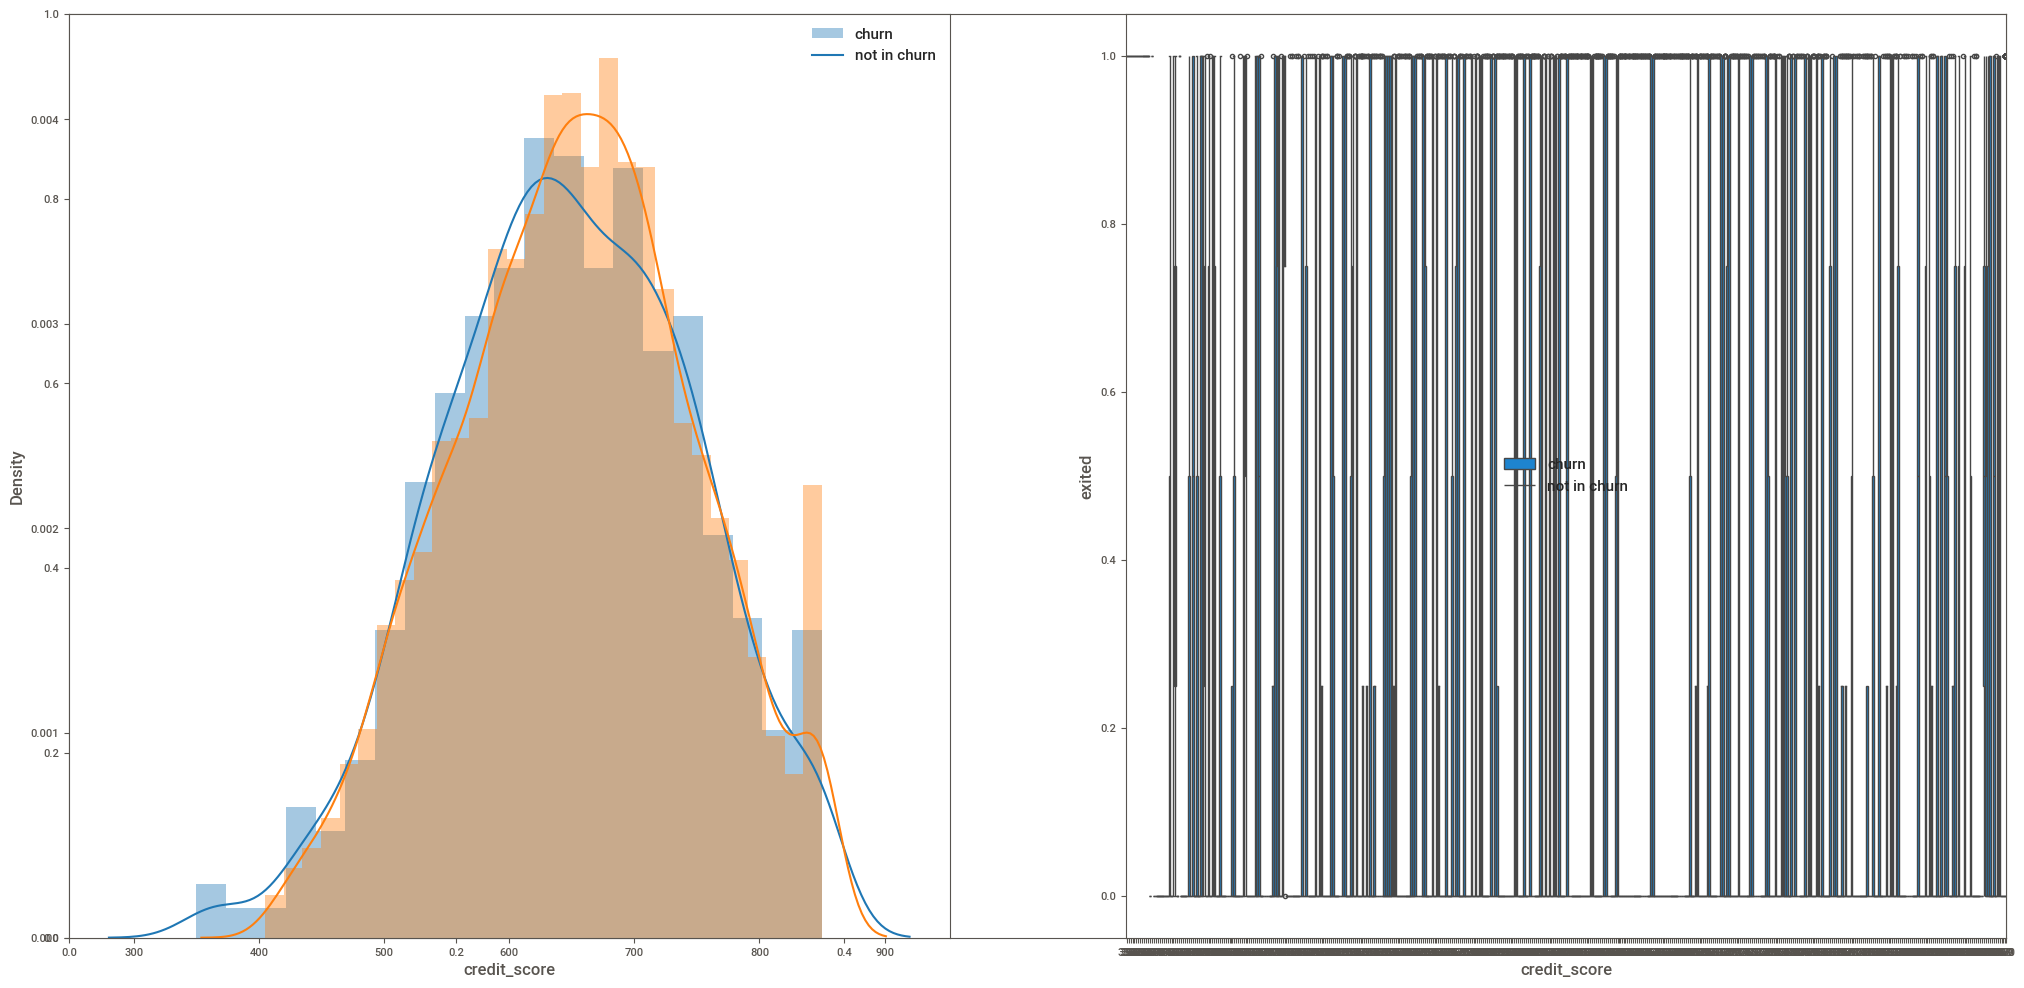

In [46]:
bivariate_churn_plots(df3, 'credit_score');

#saving figure
plt.savefig(homepath + 'reports/figures/h4a.png')

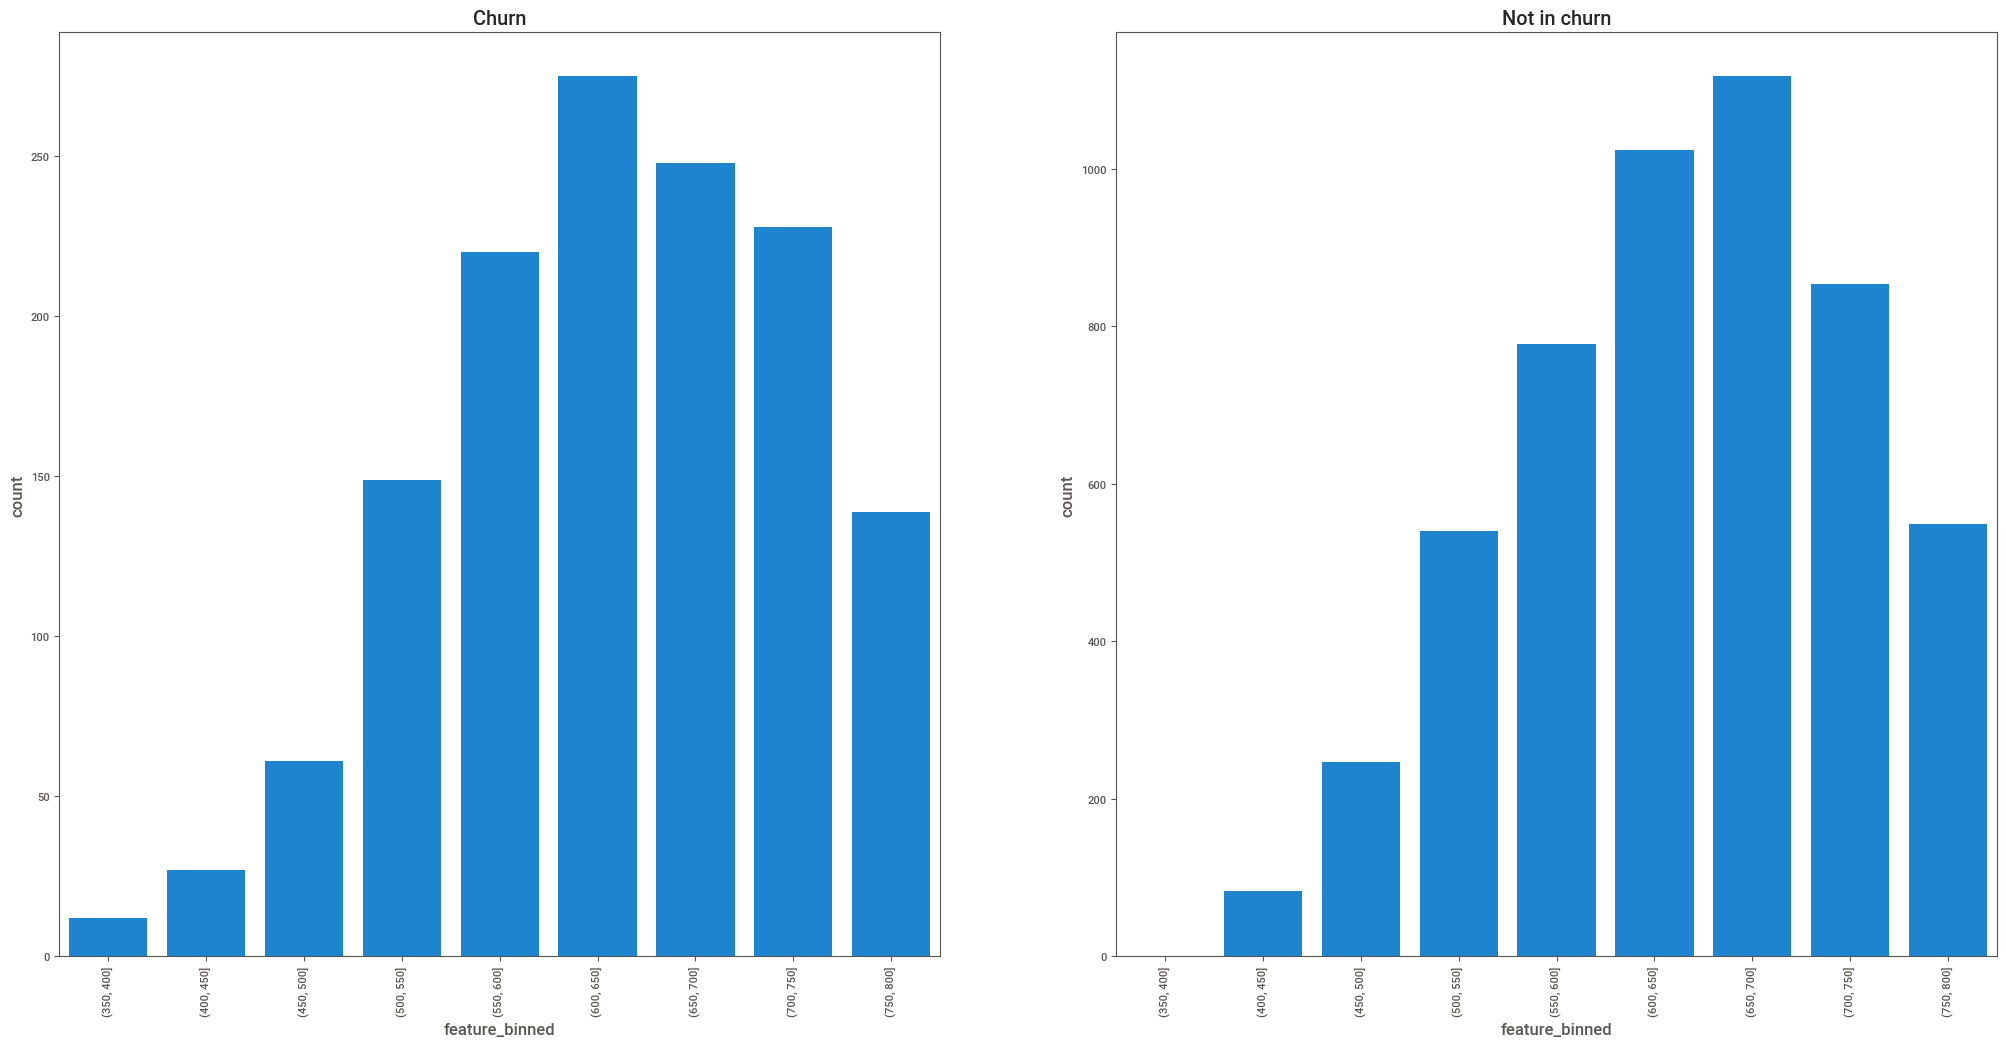

In [47]:
bivariate_bins_churn(350, 850, 50, df3, 'credit_score');

#saving figure
plt.savefig(homepath + 'reports/figures/h4b.png')

#### **H5** Clients with higher estimated salaries tend to be in churn.
**True** Clients with higher salaries has a slightly bigger chance to be a churn.

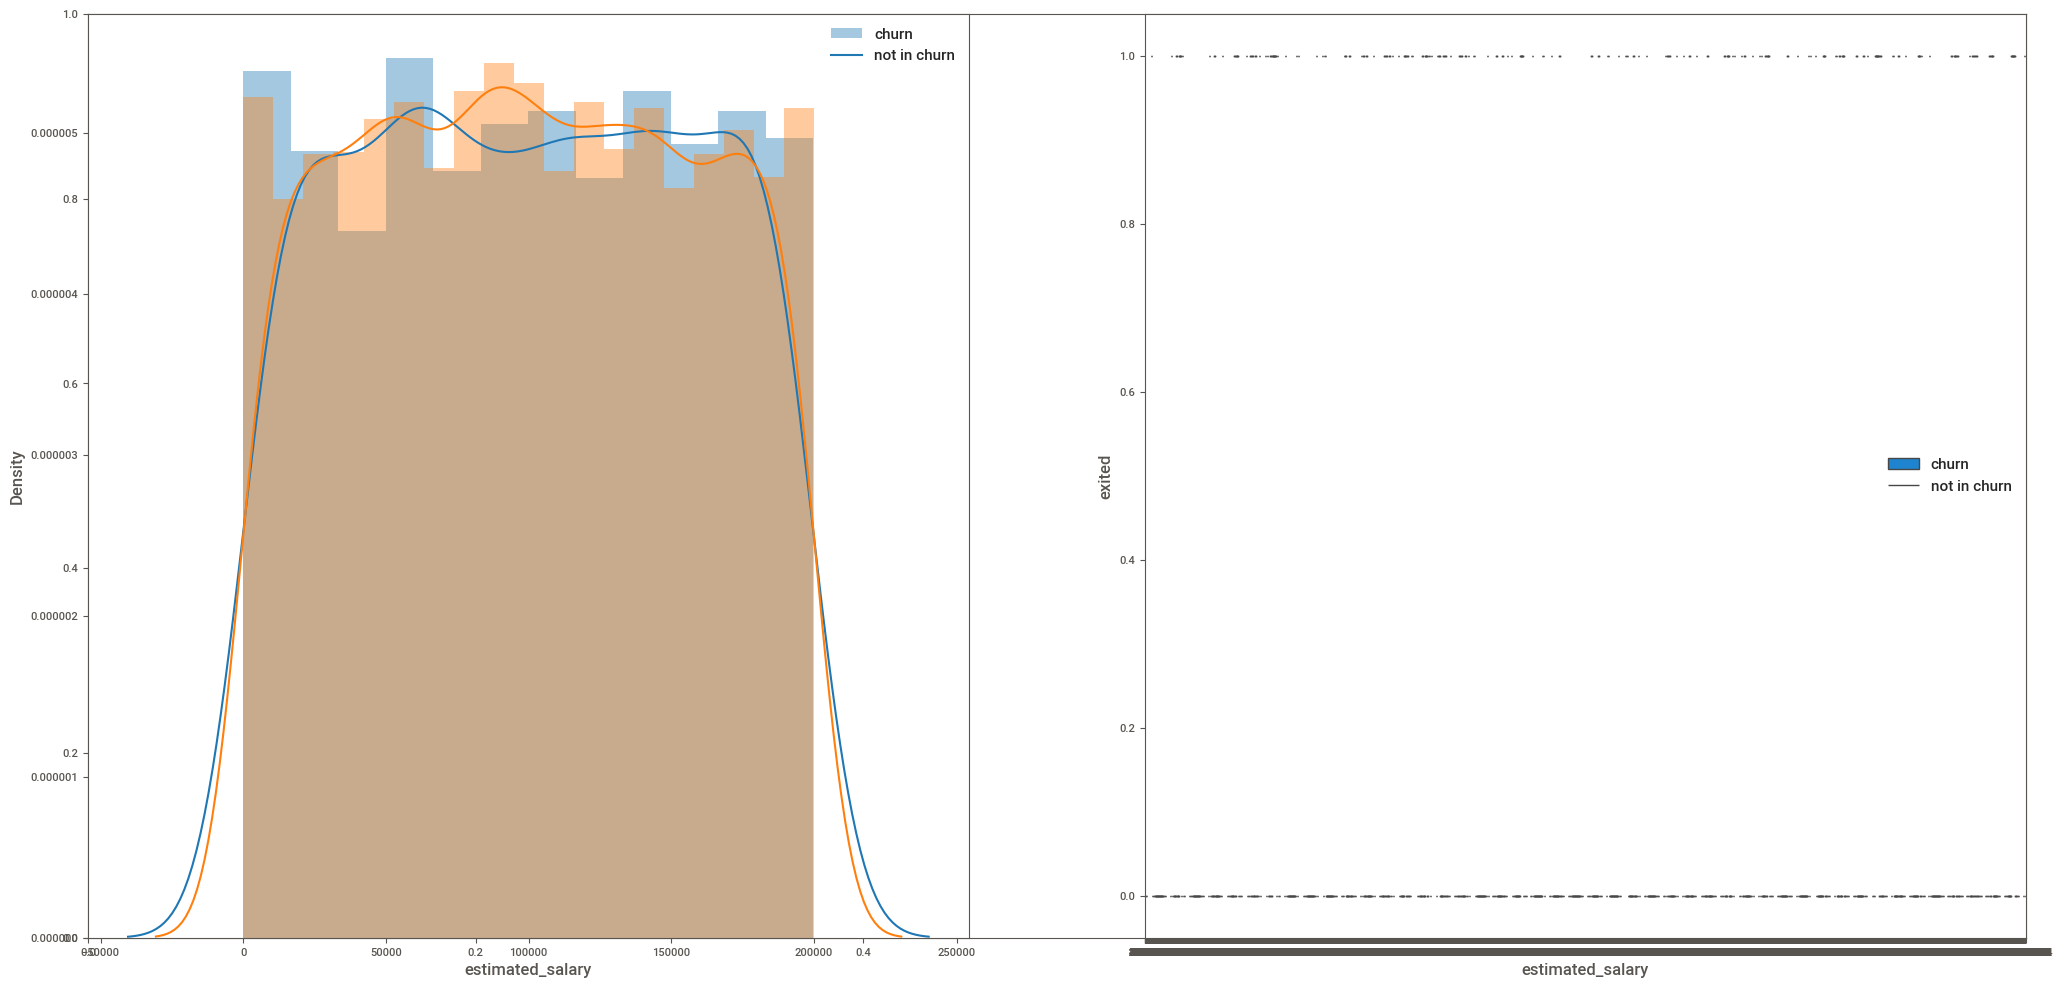

In [48]:
bivariate_churn_plots(df3, 'estimated_salary');

#saving figure
plt.savefig(homepath + 'reports/figures/h5a.png')

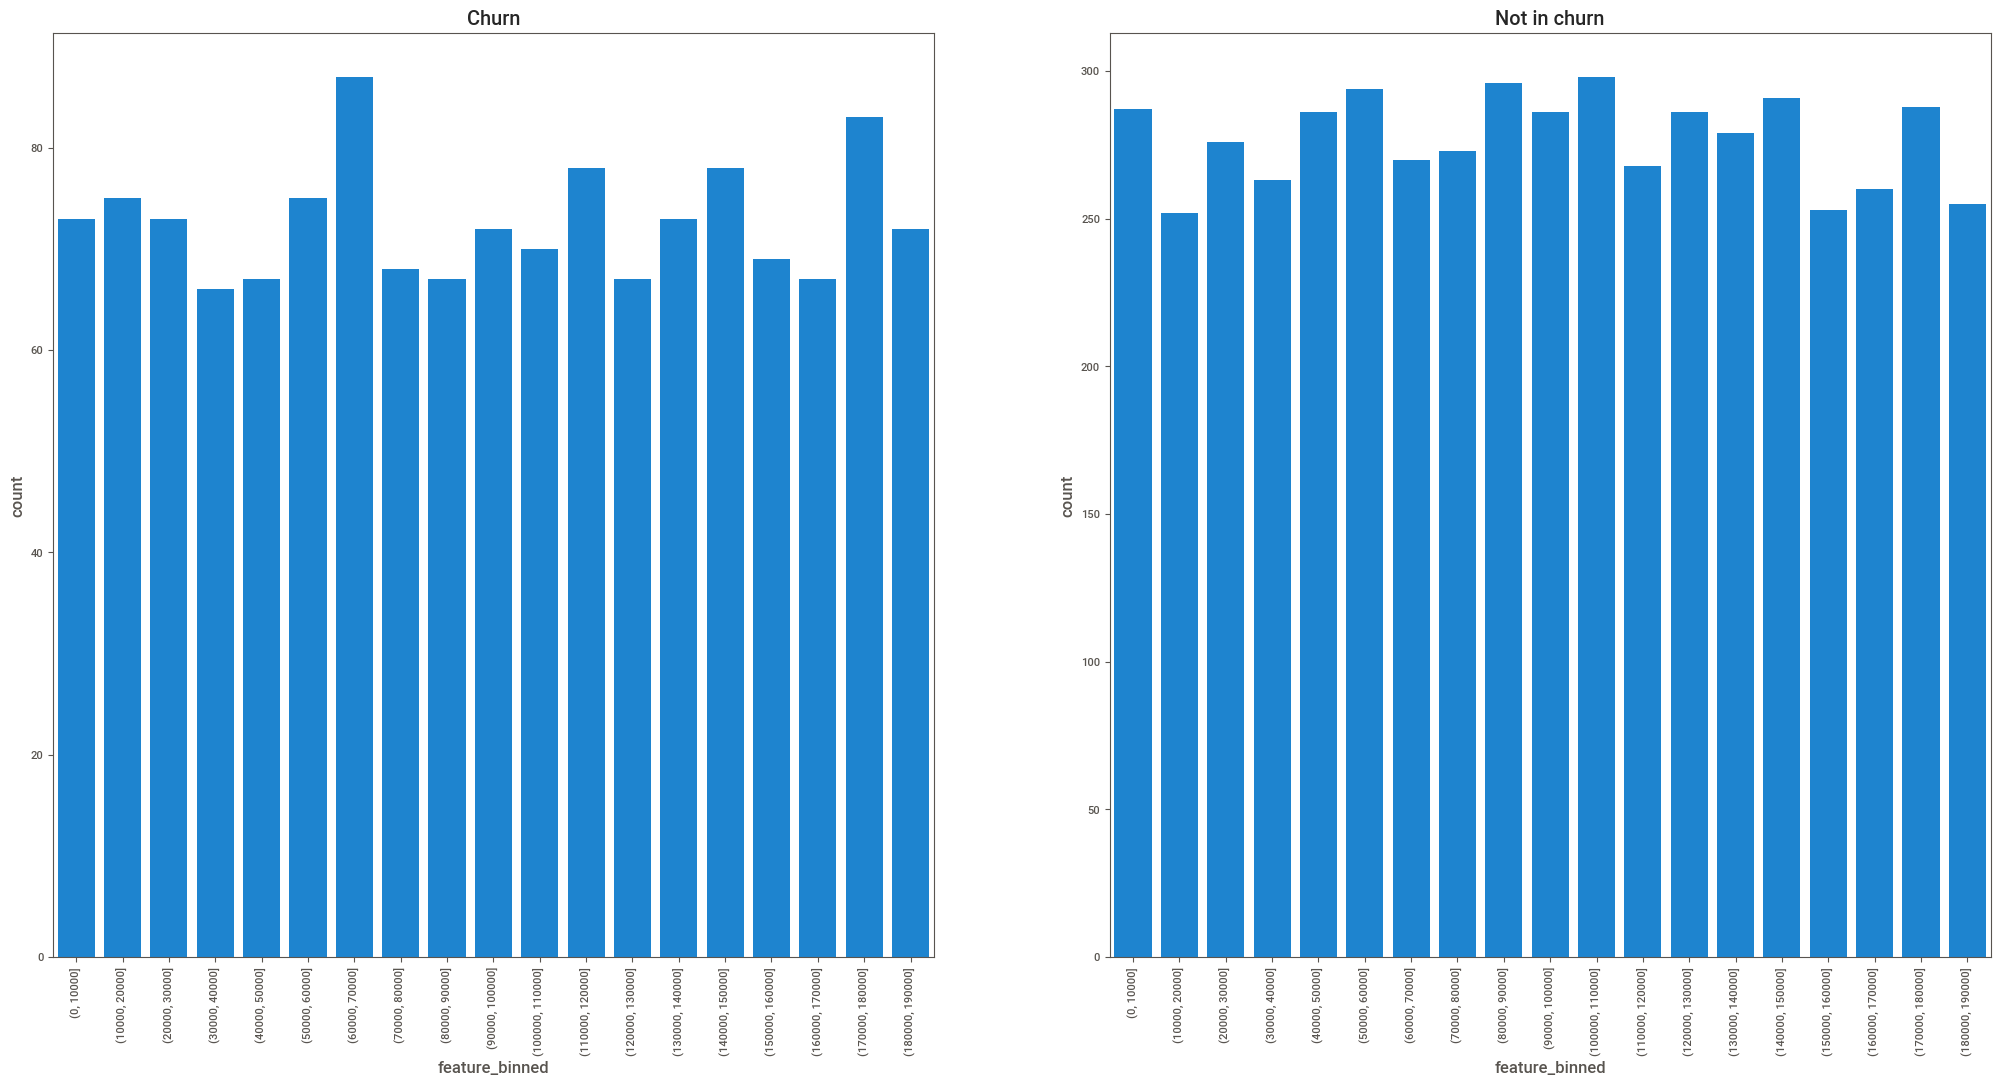

In [49]:
bivariate_bins_churn(0, 200000, 10000, df3, 'estimated_salary');

#saving figure
plt.savefig(homepath + 'reports/figures/h5b.png')

### 4.6 Multivariate Analysis

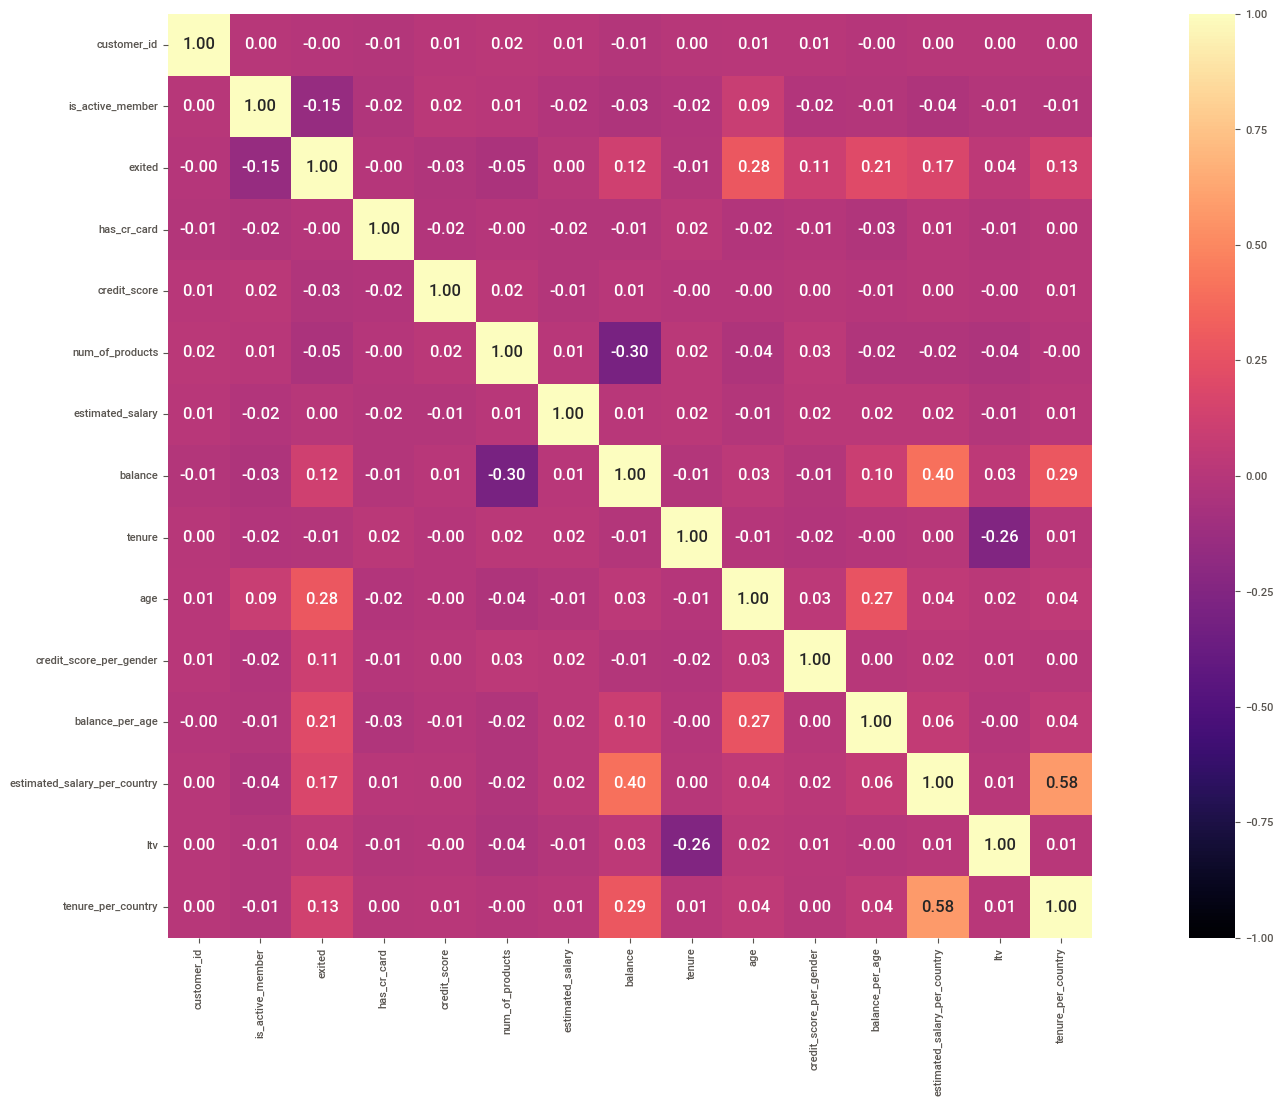

In [50]:
correlation_matrix(df3, 'pearson')

#saving figure
plt.savefig(homepath + 'reports/figures/correlation_matrix.png')

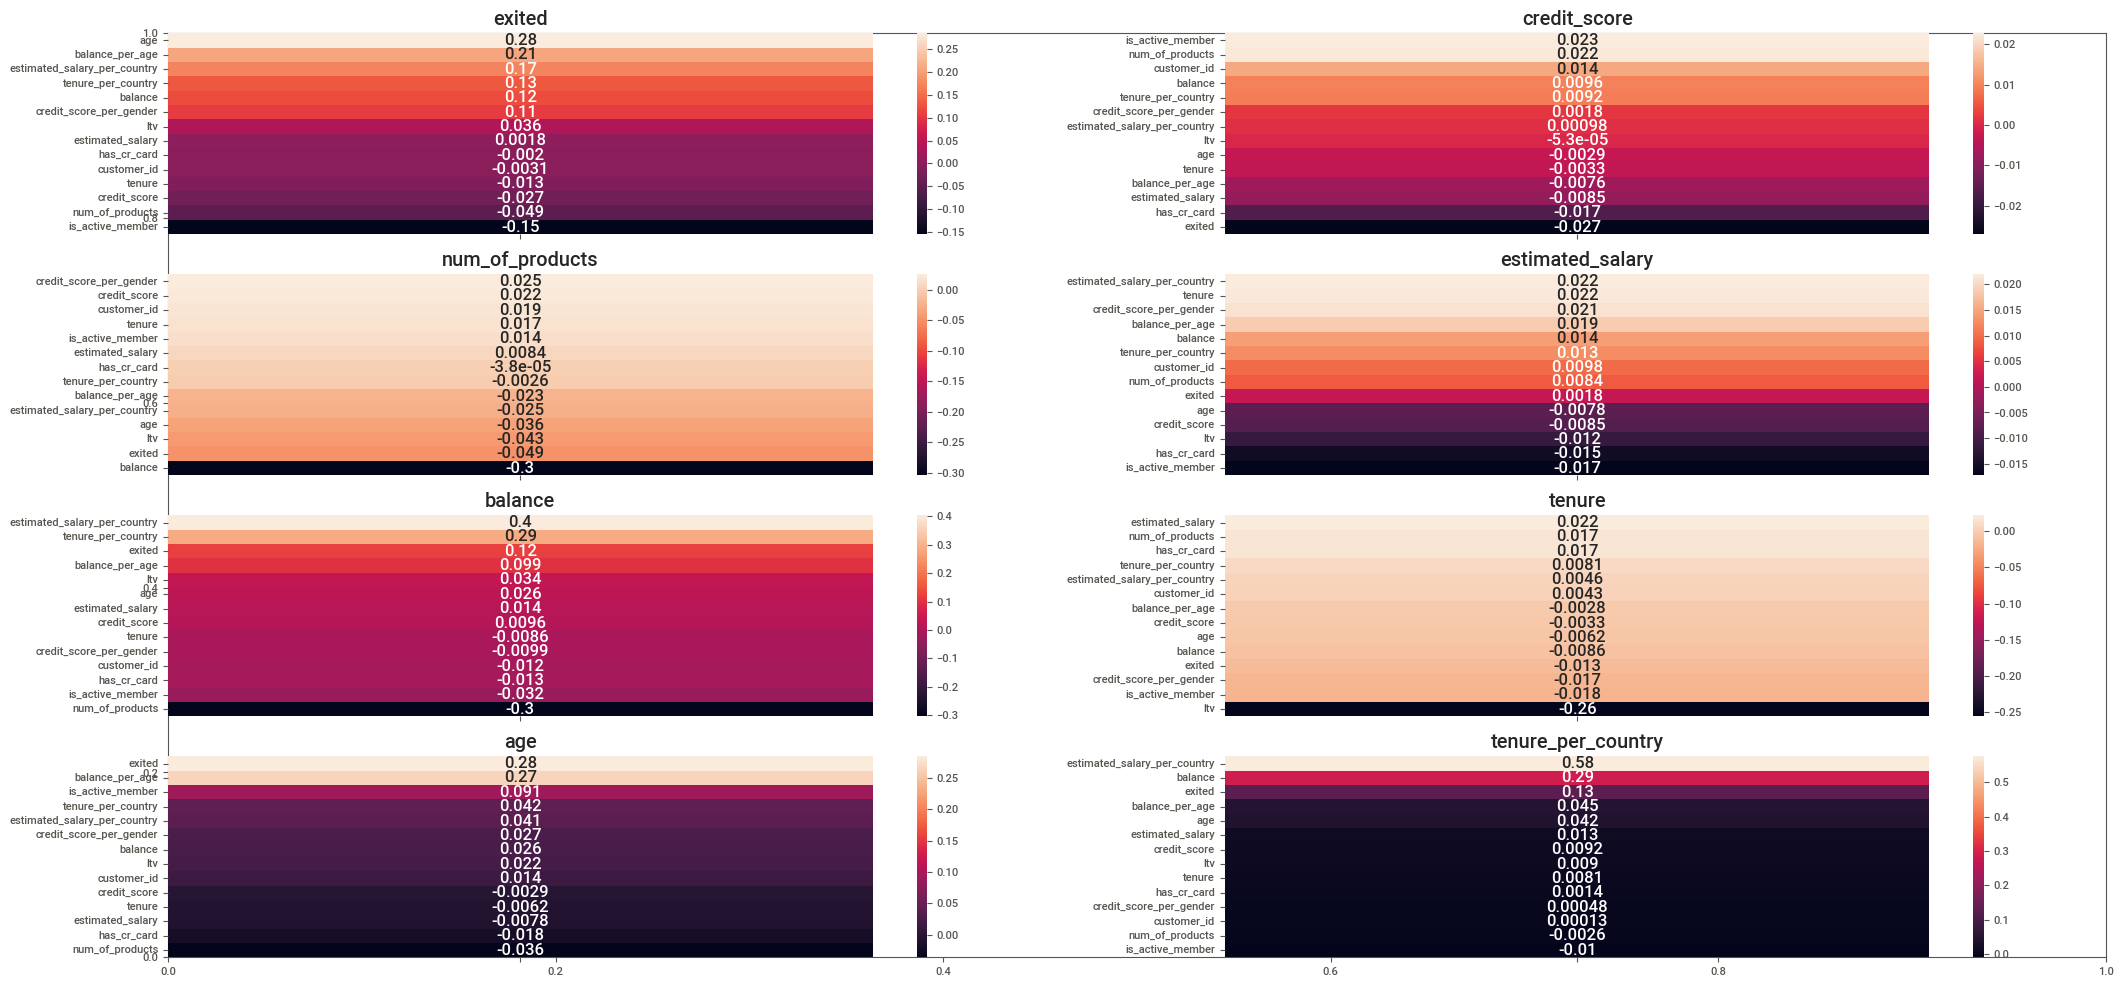

In [51]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(4, 2, 1)
correlation_ascending(df3, 'exited', 'pearson')

plt.subplot(4, 2, 2)
correlation_ascending(df3, 'credit_score', 'pearson')

plt.subplot(4, 2, 3)
correlation_ascending(df3, 'num_of_products', 'pearson')

plt.subplot(4, 2, 4)
correlation_ascending(df3, 'estimated_salary', 'pearson')

plt.subplot(4, 2, 5)
correlation_ascending(df3, 'balance', 'pearson')

plt.subplot(4, 2, 6)
correlation_ascending(df3, 'tenure', 'pearson')

plt.subplot(4, 2, 7)
correlation_ascending(df3, 'age', 'pearson')

plt.subplot(4, 2, 8)
correlation_ascending(df3, 'tenure_per_country', 'pearson');

#saving figure
plt.savefig(homepath + 'reports/figures/correlation_a.png')

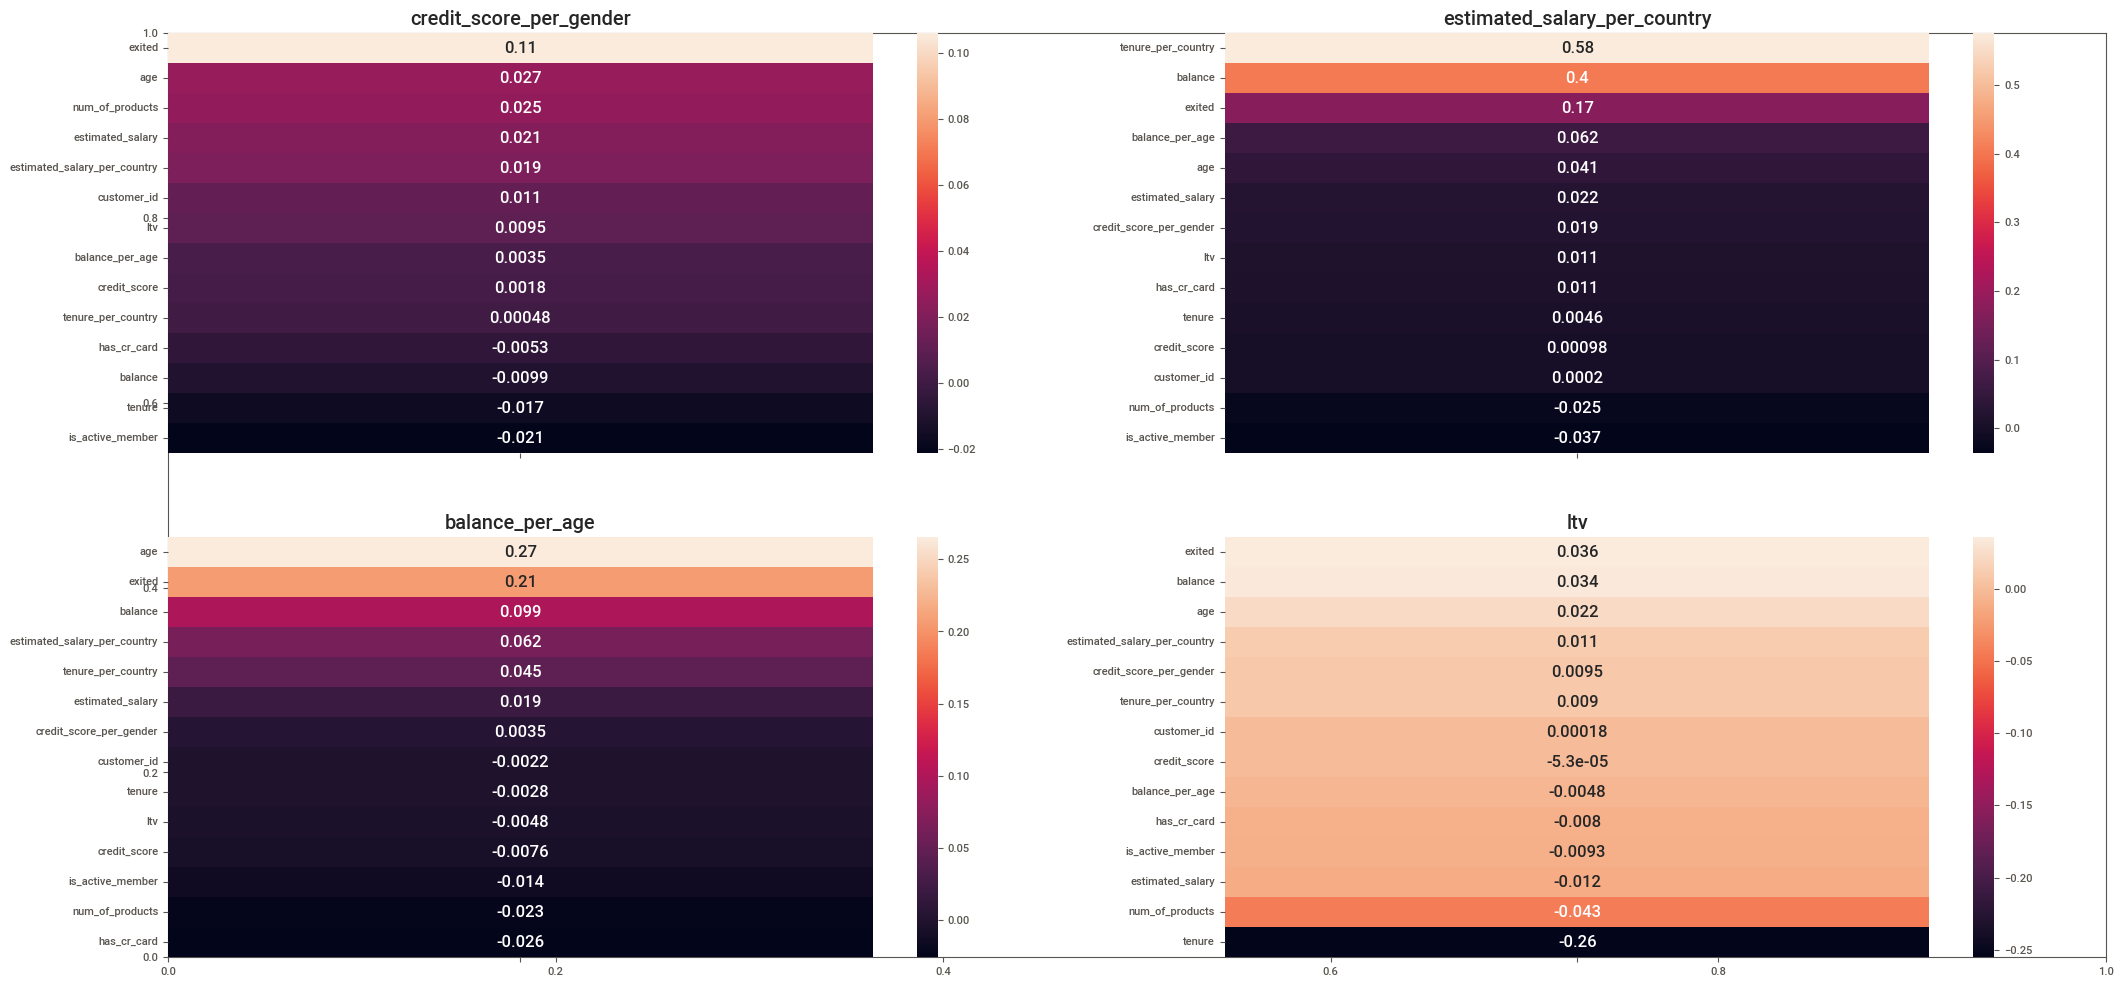

In [52]:
# creating subplots
fig, ax = plt.subplots()

plt.subplot(2, 2, 1)
correlation_ascending(df3, 'credit_score_per_gender', 'pearson')

plt.subplot(2, 2, 2)
correlation_ascending(df3, 'estimated_salary_per_country', 'pearson')

plt.subplot(2, 2, 3)
correlation_ascending(df3, 'balance_per_age', 'pearson')

plt.subplot(2, 2, 4)
correlation_ascending(df3, 'ltv', 'pearson');

#saving figure
plt.savefig(homepath + 'reports/figures/correlation_b.png')

In [53]:
df3.head()


,customer_id,is_active_member,exited,has_cr_card,credit_score,num_of_products,estimated_salary,balance,tenure,age,gender,geography,credit_score_per_gender,balance_per_age,estimated_salary_per_country,ltv,tenure_per_country
0,15779103,0,0,1,527,2,94711.430,96748.890,9,39,Female,Germany,651.817,77172.378,102062.472,77421.307,5.011
1,15696120,0,0,1,701,2,115650.630,0.000,2,30,Female,Spain,651.817,71941.826,98801.796,73662.765,4.999
2,15746995,0,0,1,724,1,12920.430,138166.300,9,31,Male,Germany,651.459,73392.437,102062.472,77421.307,5.011
3,15584452,0,0,0,667,2,167181.770,0.000,6,41,Male,France,651.459,74632.140,99419.873,76448.435,4.960
4,15602500,1,0,0,850,1,103902.110,146343.980,1,38,Male,Spain,651.459,75561.671,98801.796,78624.286,4.999


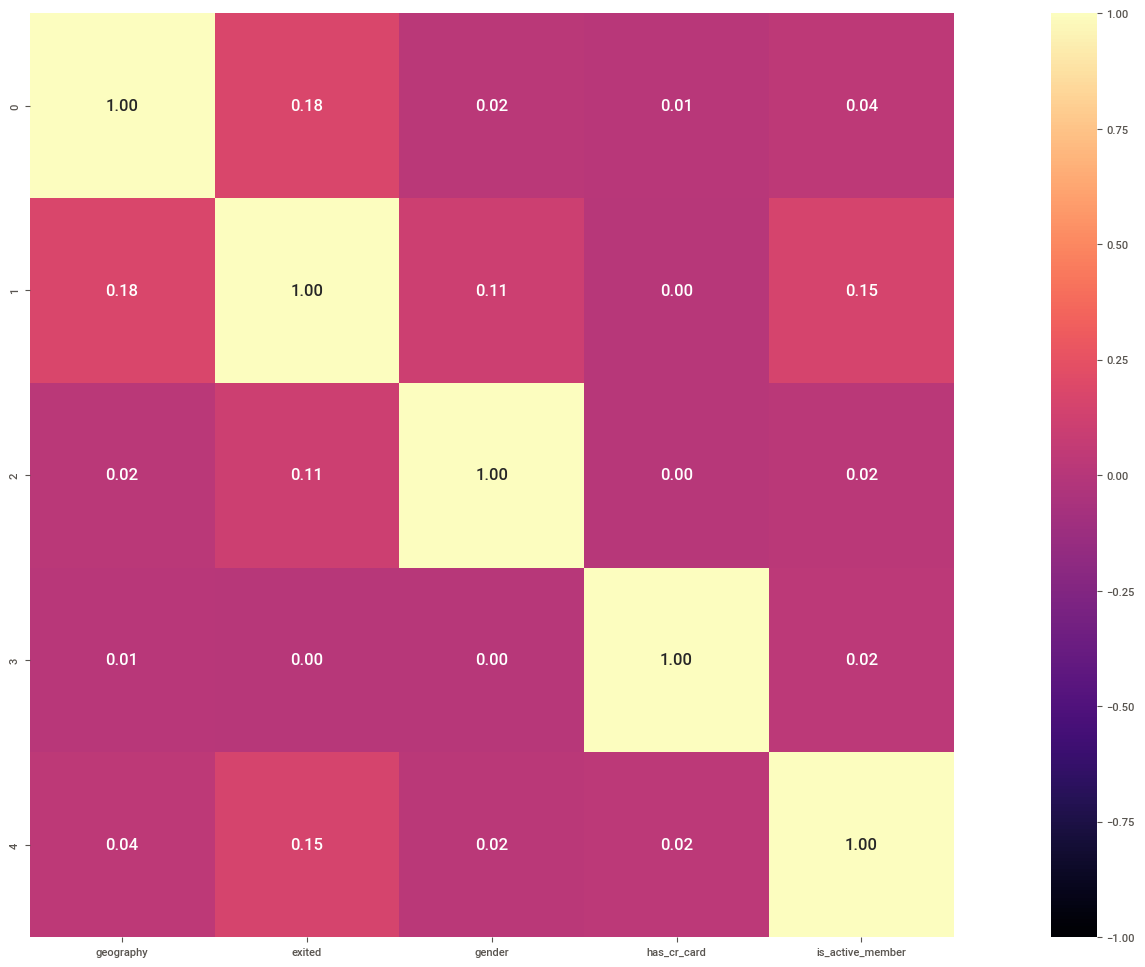

In [54]:

cat_features = df3[['geography', 'exited', 'gender', 'has_cr_card', 'is_active_member']]
cat_corr = pd.DataFrame(cramers_v(cat_features))
sns.heatmap(cat_corr, fmt = '.2f', vmin = -1, vmax = 1, annot = True, cmap = 'magma', square = True);

In [58]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [59]:

# re-scaling
min_max_scaler = ['is_active_member', 'exited', 'has_cr_card', 'estimated_salary', 'balance', 'tenure',
                  'estimated_salary_per_country', 'ltv', 'tenure_per_country', 'country', 'gender']

robust_scaler = ['credit_score', 'num_of_products', 'age',
                 'balance_per_age']

# encoding
cols_ohe = ['geography', 'gender']
cols_qe = ['is_active_member', 'has_cr_card']
cols_ge = ['gender']

In [60]:
transformer = [('mms', MinMaxScaler(), min_max_scaler),
               ('rs', RobustScaler(), robust_scaler),
               ('ohe', OneHotEncoder(), cols_ohe),
               ('qe', OneHotEncoder(), cols_qe),
               ('ge', OneHotEncoder(), cols_ge)]

preprocessor = ColumnTransformer(transformers = transformer)

In [61]:


from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression



In [62]:
classifiers_list = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

In [63]:
for classifier in classifiers_list:
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    pipe.fit(X_train, y_train)
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

ValueError: A given column is not a column of the dataframe